In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import Toronto major crime indicators (MCI)
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 

- Other crimes:
    - homicide csv https://data.torontopolice.on.ca/datasets/TorontoPS::homicide-asr-rc-tbl-002/explore?location=43.721941%2C-79.371145%2C11.78&showTable=true
    - shootings csv https://data.torontopolice.on.ca/datasets/TorontoPS::shootings-and-firearm-discharges/explore?location=21.919150%2C-39.812750%2C4.69&showTable=true
    - Theft from motor vehicle https://data.torontopolice.on.ca/datasets/TorontoPS::theft-from-motor-vehicle/explore?location=22.246462%2C-39.965802%2C4.69&showTable=true
        - theft over 5,000 is already included in MCI as 'thefy over'
    - bicycle theft https://data.torontopolice.on.ca/datasets/TorontoPS::bicycle-thefts/explore?location=21.520237%2C-39.911850%2C4.53&showTable=true


In [5]:
mci_df = pd.read_csv('./raw_data/Major_Crime_Indicators.csv')
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_41212\200617091.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_df = pd.read_csv('./raw_data/Major_Crime_Indicators.csv')


X             Y  Index_ event_unique_id Division  \
0      -8.859955e+06  5.424372e+06     110  GO-20141625305      D23   
1      -8.861110e+06  5.424036e+06     188  GO-20141272968      D23   
2      -8.861120e+06  5.417043e+06     287  GO-20141284361      D23   
3      -8.861463e+06  5.425856e+06     384  GO-20141292177      D23   
4      -8.859522e+06  5.418688e+06     438  GO-20141297201      D23   
...              ...           ...     ...             ...      ...   
281687 -8.821530e+06  5.440408e+06  241900  GO-20212225907      NSA   
281688 -8.826173e+06  5.441887e+06  241902  GO-20212226010      NSA   
281689 -8.853658e+06  5.454890e+06  242054  GO-20212238042      NSA   
281690  0.000000e+00  0.000000e+00  242102  GO-20212240466      NSA   
281691  0.000000e+00  0.000000e+00  242135  GO-20212242740      NSA   

                occurrencedate            reporteddate  \
0       2014/03/02 05:00:00+00  2014/03/02 05:00:00+00   
1       2013/12/24 05:00:00+00  2014/01/03 05:00:00+00   
2       2013/01/05 05:00:00+00  2014/01/05 05:00:00+00   
3       2013/12/31 05:00:00+00  2014/01/06 05:00:00+00   
4       2014/01/03 05:00:00+00  2014/01/07 05:00:00+00   
...                        ...                     ...   
281687  2021/10/22 04:00:00+00  2021/10/22 04:00:00+00   
281688  2021/10/08 04:00:00+00  2021/10/08 04:00:00+00   
281689  2021/11/20 05:00:00+00  2021/11/20 05:00:00+00   
281690  2021/11/18 05:00:00+00  2021/11/20 05:00:00+00   
281691  2021/11/21 05:00:00+00  2021/11/21 05:00:00+00   

                                            location_type premises_type  \
0       Single Home, House (Attach Garage, Cottage, Mo...         House   
1       Commercial Dwelling Unit (Hotel, Motel, B & B,...    Commercial   
2       Commercial Dwelling Unit (Hotel, Motel, B & B,...    Commercial   
3       Other Commercial / Corporate Places (For Profi...    Commercial   
4       Other Commercial / Corporate Places (For Profi...    Commercial   
...                                                   ...           ...   
281687  Single Home, House (Attach Garage, Cottage, Mo...         House   
281688  Single Home, House (Attach Garage, Cottage, Mo...         House   
281689                   Apartment (Rooming House, Condo)     Apartment   
281690  Single Home, House (Attach Garage, Cottage, Mo...         House   
281691  Streets, Roads, Highways (Bicycle Path, Privat...       Outside   

        ucr_code  ucr_ext              offence  reportedyear reportedmonth  \
0           1430      100              Assault          2014         March   
1           1610      200    Robbery - Mugging          2014       January   
2           1430      100              Assault          2014       January   
3           2120      200                  B&E          2014       January   
4           2120      200                  B&E          2014       January   
...          ...      ...                  ...           ...           ...   
281687      2120      200                  B&E          2021       October   
281688      2120      200                  B&E          2021       October   
281689      1430      100              Assault          2021      November   
281690      1430      100              Assault          2021      November   
281691      1420      100  Assault With Weapon          2021      November   

        reportedday  reporteddayofyear reporteddayofweek  reportedhour  \
0                 2                 61        Sunday                 8   
1                 3                  3        Friday                11   
2                 5                  5        Sunday                 5   
3                 6                  6        Monday                17   
4                 7                  7        Tuesday               10   
...             ...                ...               ...           ...   
281687           22                295        Friday                11   
281688            8                281 

In [6]:
mci_df.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId'],
      dtype='object')

## Add data for shootings and homicide

In [5]:
# read and clean shootings data
shootings = pd.read_csv('./raw_data/Shootings.csv')
shootings.drop(columns=['Time_Range', 'Death', 'Injuries'], inplace=True)
shootings.rename(columns = {'Event_Unique_ID': 'event_unique_id',
                            'Occurrence_Date': 'occurrencedate',
                            'Occurrence_year': 'occurrenceyear',
                            'Month': 'occurrencemonth',
                            'Day_of_week': 'occurrencedayofweek',
                            'Occurrence_Hour': 'occurrencehour',
                            'Longitude': 'Long',
                            'Latitude': 'Lat'}, inplace=True)
shootings['Neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in shootings['Neighbourhood']]
shootings['MCI'] = 'Shootings'

In [6]:
shootings.shape

(5328, 16)

In [7]:
# read and clean homicides data
homicide = pd.read_csv('./raw_data/Homicide.csv')
homicide.drop(columns=['Homicide_Type'], inplace=True)
homicide.rename(columns={'Event_Unique_Id': 'event_unique_id',
                            'Occurrence_year': 'occurrenceyear',
                            'Occurrence_Date': 'occurrencedate'}, inplace = True)
homicide['Neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in homicide['Neighbourhood']]
homicide['MCI'] = 'Homicide'

In [8]:
homicide.shape

(1252, 13)

In [9]:
# check columns are in the same order
pd.concat([mci_df.loc[0], shootings.loc[0], homicide.loc[0]], axis=1).T

X               Y Index_ event_unique_id Division  \
0 -8859955.190233  5424371.891363    110  GO-20141625305      D23   
0 -8854150.676948  5424331.101656      1   GO-2004133803      D31   
0 -8837967.627125  5416827.900302      1          111878      D53   

           occurrencedate            reporteddate  \
0  2014/03/02 05:00:00+00  2014/03/02 05:00:00+00   
0  2004/01/01 05:00:00+00                     NaN   
0  2004/01/03 05:00:00+00                     NaN   

                                       location_type premises_type ucr_code  \
0  Single Home, House (Attach Garage, Cottage, Mo...         House     1430   
0                                                NaN           NaN      NaN   
0                                                NaN           NaN      NaN   

  ucr_ext  offence reportedyear reportedmonth reportedday reporteddayofyear  \
0     100  Assault         2014         March           2                61   
0     NaN      NaN          NaN           NaN         NaN               NaN   
0     NaN      NaN          NaN           NaN         NaN               NaN   

  reporteddayofweek reportedhour occurrenceyear occurrencemonth occurrenceday  \
0        Sunday                8           2014           March             2   
0               NaN          NaN           2004         January           NaN   
0               NaN          NaN           2004             NaN           NaN   

  occurrencedayofyear occurrencedayofweek occurrencehour        MCI Hood_ID  \
0                  61          Sunday                  8    Assault       1   
0                 NaN          Thursday              0.0  Shootings      23   
0                 NaN                 NaN            NaN   Homicide      97   

            Neighbourhood       Long        Lat ObjectId  
0  West Humber-Clairville -79.590332  43.734013        1  
0    Pelmo Park-Humberlea -79.538189  43.733748        1  
0          Yonge-St.Clair -79.392814  43.685026        1

In [10]:
mci_df = pd.concat([mci_df, shootings, homicide], axis=0).reset_index(drop=True)

## Missing data

In [11]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


reporteddate           6580
location_type          6580
premises_type          6580
ucr_code               6580
ucr_ext                6580
offence                6580
reportedyear           6580
reportedmonth          6580
reportedday            6580
reporteddayofyear      6580
reporteddayofweek      6580
reportedhour           6580
occurrencemonth        1347
occurrenceday          6580
occurrencedayofyear    6580
occurrencedayofweek    1347
occurrencehour         1253
Hood_ID                   1
Neighbourhood             1
dtype: int64

### load neighbourhood boundaries

In [12]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson', driver='GeoJSON')

### drop 1 row with missing hood_ID and neighbourhood

In [13]:
mci_df[mci_df.Hood_ID.isna()]

X             Y  Index_ event_unique_id Division  \
281930 -8.854773e+06  5.430371e+06     439  GO-20051440086      D31   

                occurrencedate reporteddate location_type premises_type  \
281930  2005/12/01 05:00:00+00          NaN           NaN           NaN   

        ucr_code  ucr_ext offence  reportedyear reportedmonth  reportedday  \
281930       NaN      NaN     NaN           NaN           NaN          NaN   

        reporteddayofyear reporteddayofweek  reportedhour  occurrenceyear  \
281930                NaN               NaN           NaN            2005   

       occurrencemonth  occurrenceday  occurrencedayofyear  \
281930        December            NaN                  NaN   

       occurrencedayofweek  occurrencehour        MCI Hood_ID Neighbourhood  \
281930          Thursday              19.0  Shootings     NaN           NaN   

             Long        Lat  ObjectId  
281930 -79.543781  43.772936       239

In [14]:
# the event with missing Hood_ID and Neighbourhood is not in any of the neighbourhoods of City of Toronto
neighbourhoods[neighbourhoods.intersects(shapely.geometry.Point(mci_df[mci_df.Hood_ID.isna()].Long, mci_df[mci_df.Hood_ID.isna()].Lat))]

Empty GeoDataFrame
Columns: [Neighbourhood, Hood_ID, district, distance_km, Population_2014, Population_2015, Population_2016, Population_2017, Population_2018, Population_2019, Population_2020, PIC_Count2014, PIC_Count2015, PIC_Count2016, PIC_Count2017, PIC_Count2018, PIC_Count2019, PIC_Count2020, PIC_Density2014, PIC_Density2015, PIC_Density2016, PIC_Density2017, PIC_Density2018, PIC_Density2019, PIC_Density2020, PIC_Rate2014, PIC_Rate2015, PIC_Rate2016, PIC_Rate2017, PIC_Rate2018, PIC_Rate2019, PIC_Rate2020, MentalHealth_Count2014, MentalHealth_Count2015, MentalHealth_Count2016, MentalHealth_Count2017, MentalHealth_Count2018, MentalHealth_Count2019, MentalHealth_Count2020, MentalHealth_Density2014, MentalHealth_Density2015, MentalHealth_Density2016, MentalHealth_Density2017, MentalHealth_Density2018, MentalHealth_Density2019, MentalHealth_Density2020, MentalHealth_Rate2014, MentalHealth_Rate2015, MentalHealth_Rate2016, MentalHealth_Rate2017, MentalHealth_Rate2018, MentalHealth_Rate2019, MentalHealth_Rate2020, geometry]
Index: []

In [15]:
# since it's outside City of Toronto, we can safely drop it
mci_df.drop(mci_df[mci_df.Hood_ID.isna()].index, inplace=True)

In [16]:
mci_df.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId'],
      dtype='object')

### drop columns with NA which we don't need

In [17]:
# drop all columns with NA except ['occurrencemonth', 'occurrenceday', 'occurrencedayofyear','occurrencedayofweek', 'occurrencehour']
mci_df.drop(columns = mci_df.isna().sum()[mci_df.isna().sum() != 0].index.values[~mci_df.isna().sum()[mci_df.isna().sum() != 0].index.isin(['occurrencemonth', 'occurrenceday', 'occurrencedayofyear','occurrencedayofweek', 'occurrencehour'])], 
            inplace = True)
print("Columns with missing data after dropping columns")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after dropping columns


occurrencemonth        1347
occurrenceday          6579
occurrencedayofyear    6579
occurrencedayofweek    1347
occurrencehour         1253
dtype: int64

### fill na with occurence dates

In [18]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.loc[na_index]

X             Y  Index_ event_unique_id Division  \
2209   -8.862616e+06  5.424091e+06  140895  GO-20181572613      D23   
16384  -8.857044e+06  5.415568e+06  158692   GO-2019461576      D23   
16487  -8.857044e+06  5.415568e+06  158693   GO-2019461576      D23   
17680  -8.852947e+06  5.416694e+06   52257  GO-20151804633      D23   
18981  -8.851285e+06  5.416903e+06  210053  GO-20201870404      D23   
...              ...           ...     ...             ...      ...   
288267 -8.859224e+06  5.426345e+06    1366   GO-2020898005      D23   
288268 -8.830322e+06  5.431112e+06    1367   GO-2020915335      D42   
288269 -8.822707e+06  5.425298e+06    1368   GO-2020909524      D41   
288270 -8.837879e+06  5.410726e+06    1369   GO-2020971451      D52   
288271 -8.860228e+06  5.425153e+06    1370   GO-2020993900      D23   

                occurrencedate  occurrenceyear occurrencemonth  occurrenceday  \
2209    1995/01/01 05:00:00+00               0             NaN            0.0   
16384   1999/01/01 05:00:00+00               0             NaN            0.0   
16487   1999/01/01 05:00:00+00               0             NaN            0.0   
17680   1996/01/01 05:00:00+00               0             NaN            0.0   
18981   1980/01/01 05:00:00+00               0             NaN            0.0   
...                        ...             ...             ...            ...   
288267  2020/05/14 04:00:00+00            2020             NaN            NaN   
288268  2020/05/17 04:00:00+00            2020             NaN            NaN   
288269  2020/05/19 04:00:00+00            2020             NaN            NaN   
288270  2020/05/26 04:00:00+00            2020             NaN            NaN   
288271  2020/05/30 04:00:00+00            2020             NaN            NaN   

        occurrencedayofyear occurrencedayofweek  occurrencehour       MCI  \
2209                    0.0                 NaN             9.0   Assault   
16384                   0.0                 NaN             0.0   Assault   
16487                   0.0                 NaN             0.0   Assault   
17680                   0.0                 NaN             8.0   Assault   
18981                   0.0                 NaN            12.0   Assault   
...                     ...                 ...             ...       ...   
288267                  NaN                 NaN             NaN  Homicide   
288268                  NaN                 NaN             NaN  Homicide   
288269                  NaN                 NaN             NaN  Homicide   
288270                  NaN                 NaN             NaN  Homicide   
288271                  NaN                 NaN             NaN  Homicide   

       Hood_ID                      Neighbourhood       Long        Lat  \
2209         1             West Humber-Clairville -79.614235  43.732190   
16384        7   Willowridge-Martingrove-Richview -79.564180  43.676839   
16487        7   Willowridge-Martingrove-Richview -79.564180  43.676839   
17680        8           Humber Heights-Westmount -79.527375  43.684156   
18981        9           Edenbridge-Humber Valley -79.512447  43.685515   
...        ...                                ...        ...        ...   
288267       2  Mount Olive-Silverstone-Jamestown -79.583768  43.746816   
288268      46                      Pleasant View -79.324129  43.777743   
288269     138                      Eglinton East -79.255724  43.740025   
288270      77  Waterfront Communities-The Island -79.392021  43.645372   
288271       1             West Humber-Clairville -79.592783  43.739080   

        ObjectId  
2209        2210  
16384      16385  
16487      16488  
17680      17681  
18981      18982  
...          ...  
288267      1248  
288268      1249  
288269      1250  
288270      1251  
288271      1252  

[6674 rows x 18 columns]

In [19]:
# we can use occurencedate to fill these na values
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate'])

In [20]:
# however, the hour of the occurrencedate column is not reliable, so we cannot fill the na values of the hour column
# crimes should be spreaded across the day but not only within 4am and 5am
mci_df['occurrencedate'].dt.hour.describe()

count    288271.000000
mean          4.335653
std           0.472219
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: occurrencedate, dtype: float64

In [21]:
# Among those records with NA in occurrencehour, there are 1,252 records linked to homicide
# that's almost 25% of all the records linked to homicide
# therefore, we should not drop these records 
mci_df[mci_df['occurrencehour'].isna()].groupby('MCI').size()

MCI
Homicide     1252
Shootings       1
dtype: int64

In [22]:
# instead, let's drop the column for occurrencehour
mci_df.drop(columns=['occurrencehour'], inplace=True)

In [23]:
# we can use occurencedate to fill these na values
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate'])

def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrenceyear'] = fix_na('occurrenceyear',
                                  mci_df['occurrencedate'].dt.year.astype(float))
mci_df['occurrencemonth'] = fix_na('occurrencemonth',
                                   mci_df['occurrencedate'].dt.strftime("%B"))
mci_df['occurrenceday'] = fix_na('occurrenceday',
                                 mci_df['occurrencedate'].dt.day.astype(float))
mci_df['occurrencedayofyear'] = fix_na('occurrencedayofyear',
                                       mci_df['occurrencedate'].dt.dayofyear.astype(float))
mci_df['occurrencedayofweek'] = fix_na('occurrencedayofweek',
                                       mci_df['occurrencedate'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.loc[na_index]

X             Y  Index_ event_unique_id Division  \
2209   -8.862616e+06  5.424091e+06  140895  GO-20181572613      D23   
16384  -8.857044e+06  5.415568e+06  158692   GO-2019461576      D23   
16487  -8.857044e+06  5.415568e+06  158693   GO-2019461576      D23   
17680  -8.852947e+06  5.416694e+06   52257  GO-20151804633      D23   
18981  -8.851285e+06  5.416903e+06  210053  GO-20201870404      D23   
...              ...           ...     ...             ...      ...   
288267 -8.859224e+06  5.426345e+06    1366   GO-2020898005      D23   
288268 -8.830322e+06  5.431112e+06    1367   GO-2020915335      D42   
288269 -8.822707e+06  5.425298e+06    1368   GO-2020909524      D41   
288270 -8.837879e+06  5.410726e+06    1369   GO-2020971451      D52   
288271 -8.860228e+06  5.425153e+06    1370   GO-2020993900      D23   

                  occurrencedate  occurrenceyear occurrencemonth  \
2209   1995-01-01 05:00:00+00:00             0.0         January   
16384  1999-01-01 05:00:00+00:00             0.0         January   
16487  1999-01-01 05:00:00+00:00             0.0         January   
17680  1996-01-01 05:00:00+00:00             0.0         January   
18981  1980-01-01 05:00:00+00:00             0.0         January   
...                          ...             ...             ...   
288267 2020-05-14 04:00:00+00:00          2020.0             May   
288268 2020-05-17 04:00:00+00:00          2020.0             May   
288269 2020-05-19 04:00:00+00:00          2020.0             May   
288270 2020-05-26 04:00:00+00:00          2020.0             May   
288271 2020-05-30 04:00:00+00:00          2020.0             May   

        occurrenceday  occurrencedayofyear occurrencedayofweek       MCI  \
2209              0.0                  0.0              Sunday   Assault   
16384             0.0                  0.0              Friday   Assault   
16487             0.0                  0.0              Friday   Assault   
17680             0.0                  0.0              Monday   Assault   
18981             0.0                  0.0             Tuesday   Assault   
...               ...                  ...                 ...       ...   
288267           14.0                135.0            Thursday  Homicide   
288268           17.0                138.0              Sunday  Homicide   
288269           19.0                140.0             Tuesday  Homicide   
288270           26.0                147.0             Tuesday  Homicide   
288271           30.0                151.0            Saturday  Homicide   

       Hood_ID                      Neighbourhood       Long        Lat  \
2209         1             West Humber-Clairville -79.614235  43.732190   
16384        7   Willowridge-Martingrove-Richview -79.564180  43.676839   
16487        7   Willowridge-Martingrove-Richview -79.564180  43.676839   
17680        8           Humber Heights-Westmount -79.527375  43.684156   
18981        9           Edenbridge-Humber Valley -79.512447  43.685515   
...        ...                                ...        ...        ...   
288267       2  Mount Olive-Silverstone-Jamestown -79.583768  43.746816   
288268      46                      Pleasant View -79.324129  43.777743   
288269     138                      Eglinton East -79.255724  43.740025   
288270      77  Waterfront Communities-The Island -79.392021  43.645372   
288271       1             West Humber-Clairville -79.592783  43.739080   

        ObjectId  
2209        2210  
16384      16385  
16487      16488  
17680      17681  
18981      18982  
...          ...  
288267      1248  
288268      1249  
288269      1250  
288270      1251  
288271      1252  

[6674 rows x 17 columns]

In [24]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


Series([], dtype: int64)

## Checking for date inconsistencies

In [25]:
# is the year, month, day etc. consistent with the date column?
print(sum(mci_df.occurrencedate.dt.year != mci_df.occurrenceyear))
print(sum(mci_df.occurrencedate.dt.strftime("%B") != mci_df.occurrencemonth))
print(sum(mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday))
print(sum(mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear))
print(sum(mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek))

95
0
95
95
286924


### inconsistency in year

In [26]:
# Inconsistency in year column
print(mci_df[mci_df.occurrencedate.dt.year != mci_df.occurrenceyear].occurrencedate.dt.year)
mci_df.loc[mci_df.occurrencedate.dt.year != mci_df.occurrenceyear, ['occurrencedate', 'occurrenceyear']]

2209      1995
16384     1999
16487     1999
17680     1996
18981     1980
          ... 
278589    1984
279686    1988
279875    1989
280072    1979
281663    1998
Name: occurrencedate, Length: 95, dtype: int64


occurrencedate  occurrenceyear
2209   1995-01-01 05:00:00+00:00             0.0
16384  1999-01-01 05:00:00+00:00             0.0
16487  1999-01-01 05:00:00+00:00             0.0
17680  1996-01-01 05:00:00+00:00             0.0
18981  1980-01-01 05:00:00+00:00             0.0
...                          ...             ...
278589 1984-01-01 05:00:00+00:00             0.0
279686 1988-01-01 05:00:00+00:00             0.0
279875 1989-09-11 04:00:00+00:00             0.0
280072 1979-12-25 05:00:00+00:00             0.0
281663 1998-01-01 05:00:00+00:00             0.0

[95 rows x 2 columns]

In [29]:
# all of the inconsistent records have year 0
mci_df.loc[mci_df.occurrencedate.dt.year != mci_df.occurrenceyear]['occurrenceyear'].unique()

array([0.])

In [30]:
# replace with correct year
mci_df.loc[mci_df.occurrencedate.dt.year != mci_df.occurrenceyear, 'occurrenceyear'] = mci_df[mci_df.occurrencedate.dt.year != mci_df.occurrenceyear].occurrencedate.dt.year

### inconsistency in day

In [32]:
# Inconsistency in day column
print(mci_df[mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday].occurrencedate.dt.day.astype(float))
mci_df.loc[mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday, ['occurrencedate', 'occurrenceday']]

2209       1.0
16384      1.0
16487      1.0
17680      1.0
18981      1.0
          ... 
278589     1.0
279686     1.0
279875    11.0
280072    25.0
281663     1.0
Name: occurrencedate, Length: 95, dtype: float64


occurrencedate  occurrenceday
2209   1995-01-01 05:00:00+00:00            0.0
16384  1999-01-01 05:00:00+00:00            0.0
16487  1999-01-01 05:00:00+00:00            0.0
17680  1996-01-01 05:00:00+00:00            0.0
18981  1980-01-01 05:00:00+00:00            0.0
...                          ...            ...
278589 1984-01-01 05:00:00+00:00            0.0
279686 1988-01-01 05:00:00+00:00            0.0
279875 1989-09-11 04:00:00+00:00            0.0
280072 1979-12-25 05:00:00+00:00            0.0
281663 1998-01-01 05:00:00+00:00            0.0

[95 rows x 2 columns]

In [33]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday]['occurrenceday'].unique()

array([0.])

In [34]:
# replace with correct day
mci_df.loc[mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday, 'occurrenceday'] = mci_df[mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday].occurrencedate.dt.day.astype(float)

### inconsistency in day of year

In [35]:
# Inconsistency in day of year column
print(mci_df[mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear].occurrencedate.dt.dayofyear.astype(float))
mci_df.loc[mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear, ['occurrencedate', 'occurrencedayofyear']]

2209        1.0
16384       1.0
16487       1.0
17680       1.0
18981       1.0
          ...  
278589      1.0
279686      1.0
279875    254.0
280072    359.0
281663      1.0
Name: occurrencedate, Length: 95, dtype: float64


occurrencedate  occurrencedayofyear
2209   1995-01-01 05:00:00+00:00                  0.0
16384  1999-01-01 05:00:00+00:00                  0.0
16487  1999-01-01 05:00:00+00:00                  0.0
17680  1996-01-01 05:00:00+00:00                  0.0
18981  1980-01-01 05:00:00+00:00                  0.0
...                          ...                  ...
278589 1984-01-01 05:00:00+00:00                  0.0
279686 1988-01-01 05:00:00+00:00                  0.0
279875 1989-09-11 04:00:00+00:00                  0.0
280072 1979-12-25 05:00:00+00:00                  0.0
281663 1998-01-01 05:00:00+00:00                  0.0

[95 rows x 2 columns]

In [36]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear]['occurrencedayofyear'].unique()

array([0.])

In [37]:
# replace with correct day of year
mci_df.loc[mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear, 'occurrencedayofyear'] = mci_df[mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear].occurrencedate.dt.dayofyear.astype(float)

### inconsistency in day of week

In [38]:
# Inconsistency in day of week column
# data looks correct but why is it showing inconsistency?
print(mci_df[mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek].occurrencedate.dt.strftime("%A"))
mci_df.loc[mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek, ['occurrencedate', 'occurrencedayofweek']]

0            Sunday
1           Tuesday
2          Saturday
3           Tuesday
4            Friday
            ...    
287015    Wednesday
287016       Friday
287017     Saturday
287018     Saturday
287019     Saturday
Name: occurrencedate, Length: 286924, dtype: object


occurrencedate occurrencedayofweek
0      2014-03-02 05:00:00+00:00          Sunday    
1      2013-12-24 05:00:00+00:00          Tuesday   
2      2013-01-05 05:00:00+00:00          Saturday  
3      2013-12-31 05:00:00+00:00          Tuesday   
4      2014-01-03 05:00:00+00:00          Friday    
...                          ...                 ...
287015 2021-09-15 04:00:00+00:00          Wednesday 
287016 2021-09-17 04:00:00+00:00          Friday    
287017 2021-09-18 04:00:00+00:00          Saturday  
287018 2021-09-18 04:00:00+00:00          Saturday  
287019 2021-09-18 04:00:00+00:00          Saturday  

[286924 rows x 2 columns]

In [39]:
# inconsistency due to white space in this column
mci_df.occurrencedayofweek.unique()

array(['Sunday    ', 'Tuesday   ', 'Saturday  ', 'Friday    ',
       'Wednesday ', 'Monday    ', 'Thursday  ', 'Sunday', 'Friday',
       'Monday', 'Tuesday', 'Thursday', 'Saturday', 'Wednesday'],
      dtype=object)

In [40]:
mci_df.occurrencedayofweek = [x.strip() for x in mci_df.occurrencedayofweek]

In [41]:
# Now all columns are consistent with occurrencedate
print(sum(mci_df.occurrencedate.dt.year != mci_df.occurrenceyear))
print(sum(mci_df.occurrencedate.dt.strftime("%B") != mci_df.occurrencemonth))
print(sum(mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday))
print(sum(mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear))
print(sum(mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek))

0
0
0
0
0


### inconsistency in hood_ID and neighbourhood

In [42]:
# check if Hood_ID and Neighbourhood are 1-to-1
# number of unique values in Hood_ID and neighbourhood should be the same
print(len(mci_df.Hood_ID.unique()), len(mci_df.Neighbourhood.unique()))

278 144


In [43]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')

In [44]:
# duplicates in Hood_ID since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')[:2].values

array([[129, 'Agincourt North', 1484],
       ['129', 'Agincourt North', 10]], dtype=object)

In [45]:
mci_df['Hood_ID'] = mci_df['Hood_ID'].astype(str)

In [46]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')

In [47]:
# let's check with neighbourhood refers to Hood_ID = 3
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

Empty DataFrame
Columns: [Hood_ID, Neighbourhood, counts]
Index: []

In [48]:
mci_df[mci_df.Hood_ID == '3']['Neighbourhood'].unique()

array(['Thistletown-Beaumond Heights'], dtype=object)

In [50]:
mci_df.loc[(mci_df.Hood_ID == '3') & (mci_df.Neighbourhood == 'NSA'), 'Neighbourhood'] = 'Thistletown-Beaumond Heights'

In [52]:
# now it's fixed
mci_df[mci_df.Hood_ID == '3']['Neighbourhood'].unique()

array(['Thistletown-Beaumond Heights'], dtype=object)

In [53]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')
# duplicate in Hood_ID
check_duplicate[check_duplicate.duplicated(subset='Hood_ID', keep=False)].sort_values(by='Hood_ID')

Hood_ID           Neighbourhood  counts
20     117              L'Amoreaux     112
21     117               LAmoreaux    2461
22     118  Tam O'Shanter-Sullivan      41
23     118   Tam OShanter-Sullivan    1808
92      54       O'Connor-Parkview      73
93      54        OConnor-Parkview    1804

In [54]:
# fix duplicate neighbourhood
mci_df.loc[(mci_df.Hood_ID == '117') & (mci_df.Neighbourhood == 'LAmoreaux'), 'Neighbourhood'] = "L'Amoreaux"
mci_df.loc[(mci_df.Hood_ID == '118') & (mci_df.Neighbourhood == 'Tam OShanter-Sullivan'), 'Neighbourhood'] = "Tam O'Shanter-Sullivan"
mci_df.loc[(mci_df.Hood_ID == '54') & (mci_df.Neighbourhood == 'OConnor-Parkview'), 'Neighbourhood'] = "O'Connor-Parkview"

In [55]:
# Hood_ID and Neighbourhood are now 1-to-1
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='Hood_ID', keep=False)].sort_values(by='Hood_ID')

Empty DataFrame
Columns: [Hood_ID, Neighbourhood, counts]
Index: []

In [56]:
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

Empty DataFrame
Columns: [Hood_ID, Neighbourhood, counts]
Index: []

### inconsistency vs neighbourhood boundary

In [57]:
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'Hood_ID']], mci_df[['Hood_ID', 'Neighbourhood']], on=['Hood_ID'])
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

Neighbourhood_x Hood_ID Neighbourhood_y
280025  Mimico (includes Humber Bay Shores)      17          Mimico

In [58]:
mci_df.loc[(mci_df.Hood_ID == '17') & (mci_df.Neighbourhood == 'Mimico'), 'Neighbourhood'] = "Mimico (includes Humber Bay Shores)"

In [59]:
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'Hood_ID']], mci_df[['Hood_ID', 'Neighbourhood']], on=['Hood_ID'])
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

Empty DataFrame
Columns: [Neighbourhood_x, Hood_ID, Neighbourhood_y]
Index: []

## Fixing Dtypes

In [60]:
mci_df.dtypes

X                                  float64
Y                                  float64
Index_                               int64
event_unique_id                     object
Division                            object
occurrencedate         datetime64[ns, UTC]
occurrenceyear                     float64
occurrencemonth                     object
occurrenceday                      float64
occurrencedayofyear                float64
occurrencedayofweek                 object
MCI                                 object
Hood_ID                             object
Neighbourhood                       object
Long                               float64
Lat                                float64
ObjectId                             int64
dtype: object

In [61]:
# 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear' should not be of type float
mci_df.columns[mci_df.dtypes == float]

Index(['X', 'Y', 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear',
       'Long', 'Lat'],
      dtype='object')

In [62]:
for x in ['occurrenceyear', 'occurrenceday', 'occurrencedayofyear']:
    mci_df[x] = mci_df[x].astype(int)

## Imputing missing longitude and latitude

array([[<AxesSubplot:title={'center':'Long'}>,
        <AxesSubplot:title={'center':'Lat'}>]], dtype=object)

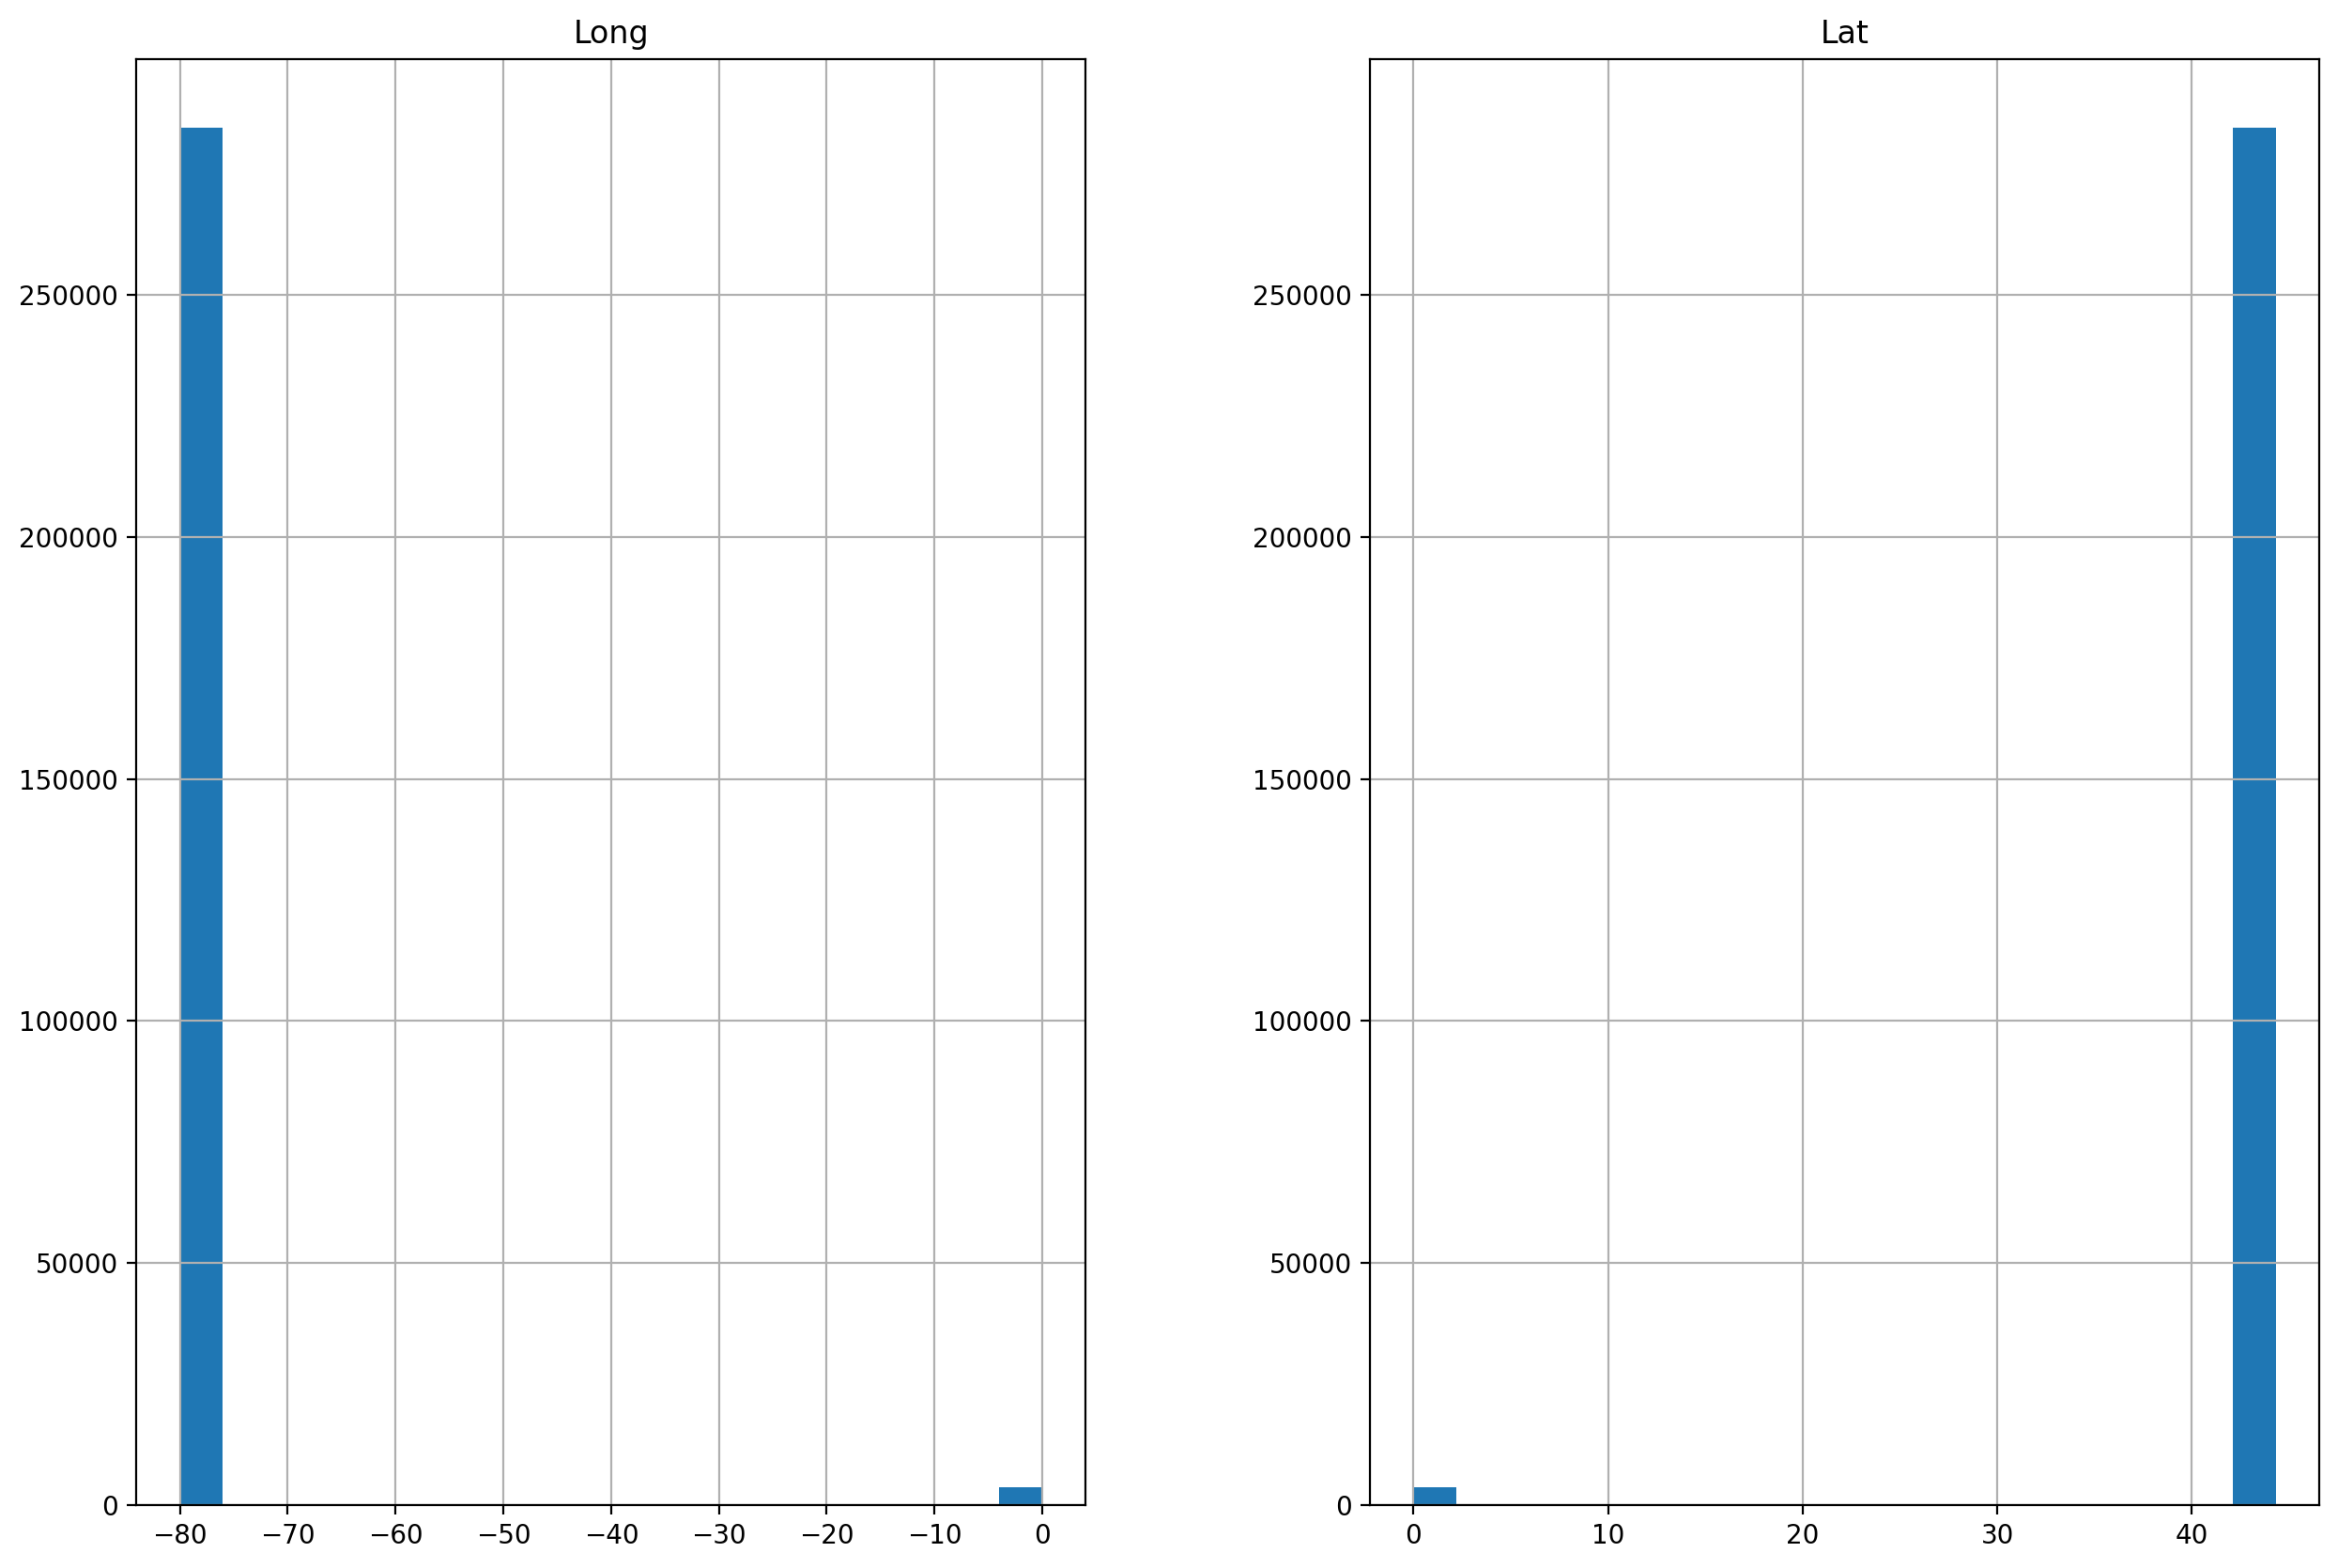

In [63]:
# missing long and lat values are stored as 0
mci_df[['Long','Lat']].hist(bins=20)

In [64]:
mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0), ["Neighbourhood", "Hood_ID"]].value_counts()

Neighbourhood                        Hood_ID
NSA                                  NSA        3400
Wexford/Maryvale                     119          57
Yorkdale-Glen Park                   31           38
West Hill                            136          25
Bay Street Corridor                  76           17
York University Heights              27           15
Bendale                              127          15
Glenfield-Jane Heights               25           13
Kennedy Park                         124           7
Mimico (includes Humber Bay Shores)  17            6
Tam O'Shanter-Sullivan               118           5
Highland Creek                       134           5
Victoria Village                     43            5
Downsview-Roding-CFB                 26            4
Pelmo Park-Humberlea                 23            4
Newtonbrook East                     50            4
Clairlea-Birchmount                  120           4
Bathurst Manor                       34            4
H

### Estimate with given neighbourhood

In [65]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['Long'] == 0) & (mci_df['Lat'] == 0) & (mci_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [66]:
missing_location = mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0)].index
mci_df.loc[missing_location]

X    Y  Index_ event_unique_id Division            occurrencedate  \
2720    0.0  0.0  136341  GO-20181222720      D23 2018-07-05 04:00:00+00:00   
4244    0.0  0.0  242874  GO-20212303850      D23 2021-04-25 04:00:00+00:00   
8300    0.0  0.0  109689  GO-20171616525      D23 2017-09-06 04:00:00+00:00   
9725    0.0  0.0  182356  GO-20192152732      D23 2019-11-07 05:00:00+00:00   
10561   0.0  0.0    4795  GO-20141665589      D13 2014-03-08 05:00:00+00:00   
...     ...  ...     ...             ...      ...                       ...   
265853  0.0  0.0  145941  GO-20181939820      D43 2018-10-20 04:00:00+00:00   
266782  0.0  0.0  200779  GO-20201116842      D43 2020-06-17 04:00:00+00:00   
270476  0.0  0.0  177335  GO-20191794829      D43 2019-09-18 04:00:00+00:00   
273148  0.0  0.0  138713  GO-20181409483      D41 2018-07-31 04:00:00+00:00   
273842  0.0  0.0  177492  GO-20191808146      D43 2019-09-20 04:00:00+00:00   

        occurrenceyear occurrencemonth  occurrenceday  occurrencedayofyear  \
2720              2018            July              5                  186   
4244              2021           April             25                  115   
8300              2017       September              6                  249   
9725              2019        November              7                  311   
10561             2014           March              8                   67   
...                ...             ...            ...                  ...   
265853            2018         October             20                  293   
266782            2020            June             17                  169   
270476            2019       September             18                  261   
273148            2018            July             31                  212   
273842            2019       September             20                  263   

       occurrencedayofweek      MCI Hood_ID  \
2720              Thursday  Assault       1   
4244                Sunday  Assault       1   
8300             Wednesday  Assault       2   
9725              Thursday  Assault       2   
10561             Saturday  Assault       3   
...                    ...      ...     ...   
265853            Saturday  Robbery     136   
266782           Wednesday  Assault     136   
270476           Wednesday  Assault     137   
273148             Tuesday  Assault     138   
273842              Friday  Robbery     138   

                            Neighbourhood  Long  Lat  ObjectId  
2720               West Humber-Clairville   0.0  0.0      2721  
4244               West Humber-Clairville   0.0  0.0      4245  
8300    Mount Olive-Silverstone-Jamestown   0.0  0.0      8301  
9725    Mount Olive-Silverstone-Jamestown   0.0  0.0      9726  
10561        Thistletown-Beaumond Heights   0.0  0.0     10562  
...                                   ...   ...  ...       ...  
265853                          West Hill   0.0  0.0    265854  
266782                          West Hill   0.0  0.0    266783  
270476                             Woburn   0.0  0.0    270477  
273148                      Eglinton East   0.0  0.0    273149  
273842                      Eglinton East   0.0  0.0    273843  

[278 rows x 17 columns]

In [67]:
missing_count = mci_df.loc[missing_location]['Hood_ID'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'Hood_ID', 'Hood_ID':'count'})
missing_count

Hood_ID  count
0      119     57
1       31     38
2      136     25
3       76     17
4       27     15
5      127     15
6       25     13
7      124      7
8       17      6
9      134      5
10      43      5
11     118      5
12      34      4
13     120      4
14      50      4
15      26      4
16      23      4
17      24      3
18      21      3
19     128      3
20      55      2
21     121      2
22     117      2
23      95      2
24      70      2
25       1      2
26      51      2
27      48      2
28       3      2
29       2      2
30      46      2
31     138      2
32      82      1
33     123      1
34     137      1
35      73      1
36       5      1
37       7      1
38       8      1
39      14      1
40      19      1
41      97      1
42      32      1
43      36      1
44      49      1
45      77      1
46     102      1
47      98      1
48      41      1

In [68]:
mci_df

X             Y  Index_ event_unique_id Division  \
0      -8.859955e+06  5.424372e+06     110  GO-20141625305      D23   
1      -8.861110e+06  5.424036e+06     188  GO-20141272968      D23   
2      -8.861120e+06  5.417043e+06     287  GO-20141284361      D23   
3      -8.861463e+06  5.425856e+06     384  GO-20141292177      D23   
4      -8.859522e+06  5.418688e+06     438  GO-20141297201      D23   
...              ...           ...     ...             ...      ...   
284866 -8.859224e+06  5.426345e+06    1366   GO-2020898005      D23   
284867 -8.830322e+06  5.431112e+06    1367   GO-2020915335      D42   
284868 -8.822707e+06  5.425298e+06    1368   GO-2020909524      D41   
284869 -8.837879e+06  5.410726e+06    1369   GO-2020971451      D52   
284870 -8.860228e+06  5.425153e+06    1370   GO-2020993900      D23   

                  occurrencedate  occurrenceyear occurrencemonth  \
0      2014-03-02 05:00:00+00:00            2014           March   
1      2013-12-24 05:00:00+00:00            2013        December   
2      2013-01-05 05:00:00+00:00            2013         January   
3      2013-12-31 05:00:00+00:00            2013        December   
4      2014-01-03 05:00:00+00:00            2014         January   
...                          ...             ...             ...   
284866 2020-05-14 04:00:00+00:00            2020             May   
284867 2020-05-17 04:00:00+00:00            2020             May   
284868 2020-05-19 04:00:00+00:00            2020             May   
284869 2020-05-26 04:00:00+00:00            2020             May   
284870 2020-05-30 04:00:00+00:00            2020             May   

        occurrenceday  occurrencedayofyear occurrencedayofweek  \
0                   2                   61              Sunday   
1                  24                  358             Tuesday   
2                   5                    5            Saturday   
3                  31                  365             Tuesday   
4                   3                    3              Friday   
...               ...                  ...                 ...   
284866             14                  135            Thursday   
284867             17                  138              Sunday   
284868             19                  140             Tuesday   
284869             26                  147             Tuesday   
284870             30                  151            Saturday   

                    MCI Hood_ID                      Neighbourhood       Long  \
0               Assault       1             West Humber-Clairville -79.590332   
1               Robbery       1             West Humber-Clairville -79.600701   
2               Assault       1             West Humber-Clairville -79.600794   
3       Break and Enter       1             West Humber-Clairville -79.603876   
4       Break and Enter       1             West Humber-Clairville -79.586443   
...                 ...     ...                                ...        ...   
284866         Homicide       2  Mount Olive-Silverstone-Jamestown -79.583768   
284867         Homicide      46                      Pleasant View -79.324129   
284868         Homicide     138                      Eglinton East -79.255724   
284869         Homicide      77  Waterfront Communities-The Island -79.392021   
284870         Homicide       1             West Humber-Clairville -79.592783   

              Lat  ObjectId  
0       43.734013         1  
1       43.731834         2  
2       43.686423         3  
3       43.743642         4  
4       43.697108         5  
...           ...       ...  
284866  43.746816      1248  
284867  43.777743      1249  
284868  43.740025      1250  
284869  43.645372      1251  
284870  43.739080      1252  

[284871 rows x 17 columns]

### Generate random locations given a neighbourhood

In [69]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['Hood_ID'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.bounds.values.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighbourhood


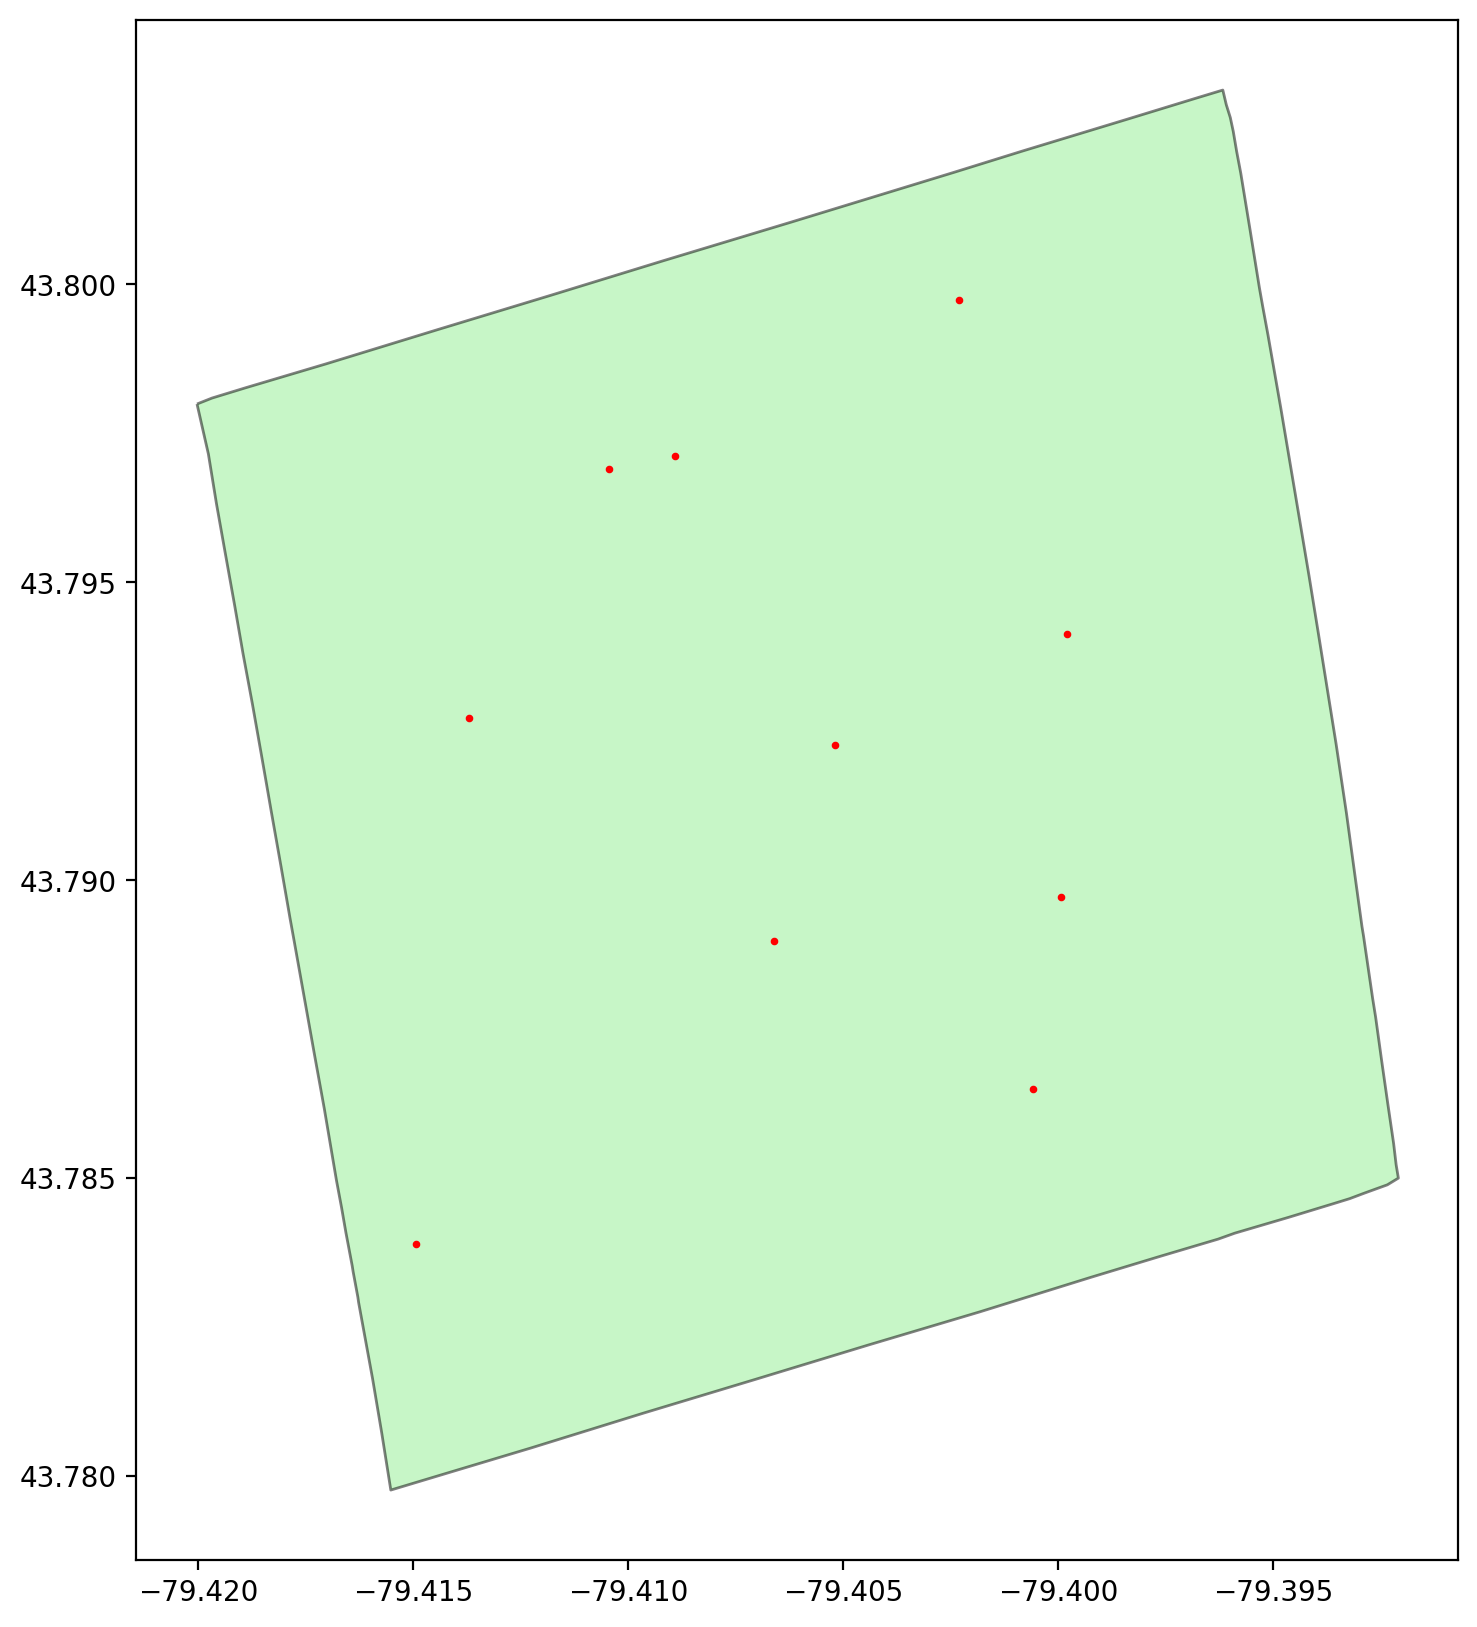

In [70]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighbourhood
# no red dots should be outside the neighbourhood
ax = neighbourhoods.loc[neighbourhoods['Hood_ID'] == str(hood)].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [71]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['Hood_ID']), axis=1)

78 points generated but only include the 57 points within the neighbourhood
68 points generated but only include the 38 points within the neighbourhood
36 points generated but only include the 25 points within the neighbourhood
33 points generated but only include the 17 points within the neighbourhood
21 points generated but only include the 15 points within the neighbourhood
25 points generated but only include the 15 points within the neighbourhood
17 points generated but only include the 13 points within the neighbourhood
11 points generated but only include the 7 points within the neighbourhood
12 points generated but only include the 6 points within the neighbourhood
11 points generated but only include the 5 points within the neighbourhood
6 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
20 points generated but only include the 4 points within the neighbourhood
11 points generated 

In [72]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

Hood_ID  count                                               Long  \
0      119     57  [-79.2905474645034, -79.31024017310659, -79.28...   
1       31     38  [-79.4499056676438, -79.44883602114473, -79.45...   
2      136     25  [-79.18296212725186, -79.19663494516615, -79.1...   
3       76     17  [-79.38932911965928, -79.38449277038399, -79.3...   
4       27     15  [-79.50615108937204, -79.49818915895317, -79.4...   
5      127     15  [-79.26173575446603, -79.25071559017856, -79.2...   
6       25     13  [-79.52250802047399, -79.52515598534787, -79.5...   
7      124      7  [-79.2698888813491, -79.26348211881192, -79.25...   
8       17      6  [-79.48539949794953, -79.48636352360387, -79.5...   
9      134      5  [-79.17564550360225, -79.17614106413124, -79.1...   
10      43      5  [-79.31025363653924, -79.32092412537807, -79.3...   
11     118      5  [-79.29767732901965, -79.32232303122326, -79.2...   
12      34      4  [-79.4376689202518, -79.45695716971886, -79.45...   
13     120      4  [-79.28623756894703, -79.2795796634251, -79.27...   
14      50      4  [-79.39493558317892, -79.41882559960113, -79.4...   
15      26      4  [-79.47948435013984, -79.5100491869697, -79.49...   
16      23      4  [-79.5156199521706, -79.53497930938873, -79.53...   
17      24      3  [-79.52511446132782, -79.53143572959488, -79.5...   
18      21      3  [-79.56162486398678, -79.54388610081277, -79.5...   
19     128      3  [-79.24497282305501, -79.27670961768489, -79.2...   
20      55      2           [-79.35492647398506, -79.36004095819271]   
21     121      2           [-79.28515332114694, -79.27488503131676]   
22     117      2           [-79.32023462103517, -79.30990984533267]   
23      95      2           [-79.40809989702096, -79.40823667512875]   
24      70      2            [-79.33840726892258, -79.3562558290554]   
25       1      2            [-79.56722041726331, -79.6159356893364]   
26      51      2           [-79.41322373386049, -79.40120406567426]   
27      48      2           [-79.34831007369016, -79.36346101722364]   
28       3      2           [-79.55511843754482, -79.56110107509437]   
29       2      2           [-79.58966535246573, -79.57024872568851]   
30      46      2            [-79.33160612008179, -79.3303583806096]   
31     138      2            [-79.23480394108957, -79.2432075818137]   
32      82      1                               [-79.41904765402431]   
33     123      1                               [-79.25014629062906]   
34     137      1                                [-79.2250157955355]   
35      73      1                               [-79.36793208923083]   
36       5      1                               [-79.55276653604268]   
37       7      1                               [-79.56389586110546]   
38       8      1                               [-79.50636831855549]   
39      14      1                               [-79.55493637586791]   
40      19      1                               [-79.52786123954405]   
41      97      1                               [-79.39820063762667]   
42      32      1                                [-79.4387986539579]   
43      36      1                               [-79.42999273835414]   
44      49      1                               [-79.39175133671543]   
45      77      1                               [-79.38284928950915]   
46     102      1                               [-79.42034808860812]   
47      98      1                               [-79.37165996287014]   
48      41      1                               [-79.36372237029842]   

                                                  Lat  len  
0   [43.73845162529402, 43.75118356521948, 43.7450...   57  
1   [43.72667387681818, 43.71306448845523, 43.7229...   38  
2   [43.77929081550005, 43.77017760574194, 43.7777...   25  
3   [43.66365378334848, 43.65329698972922, 43.6624...   17  
4   [43.754671908621695, 43.75079559393119, 43.762...   15  
5   [43.75266128515352, 43.743225602

In [73]:
# impute the missing long and lat values
for i in missing_count["Hood_ID"].unique():    
    index = (mci_df['Hood_ID'] == str(i)) & ((mci_df['Long'] == 0) | (mci_df['Lat'] == 0))
    # mci_df.loc[index, ['Long', 'Lat']] = 
    mci_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(mci_df.loc[index, 'Long'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Long'].values[0],
                                                                  mci_df.loc[index, 'Long']),
                                                         np.where(mci_df.loc[index, 'Lat'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Lat'].values[0],
                                                                  mci_df.loc[index, 'Lat'])]).T.values

In [74]:
# check missing long and lat values are now imputed
mci_df.loc[missing_location]

X    Y  Index_ event_unique_id Division            occurrencedate  \
2720    0.0  0.0  136341  GO-20181222720      D23 2018-07-05 04:00:00+00:00   
4244    0.0  0.0  242874  GO-20212303850      D23 2021-04-25 04:00:00+00:00   
8300    0.0  0.0  109689  GO-20171616525      D23 2017-09-06 04:00:00+00:00   
9725    0.0  0.0  182356  GO-20192152732      D23 2019-11-07 05:00:00+00:00   
10561   0.0  0.0    4795  GO-20141665589      D13 2014-03-08 05:00:00+00:00   
...     ...  ...     ...             ...      ...                       ...   
265853  0.0  0.0  145941  GO-20181939820      D43 2018-10-20 04:00:00+00:00   
266782  0.0  0.0  200779  GO-20201116842      D43 2020-06-17 04:00:00+00:00   
270476  0.0  0.0  177335  GO-20191794829      D43 2019-09-18 04:00:00+00:00   
273148  0.0  0.0  138713  GO-20181409483      D41 2018-07-31 04:00:00+00:00   
273842  0.0  0.0  177492  GO-20191808146      D43 2019-09-20 04:00:00+00:00   

        occurrenceyear occurrencemonth  occurrenceday  occurrencedayofyear  \
2720              2018            July              5                  186   
4244              2021           April             25                  115   
8300              2017       September              6                  249   
9725              2019        November              7                  311   
10561             2014           March              8                   67   
...                ...             ...            ...                  ...   
265853            2018         October             20                  293   
266782            2020            June             17                  169   
270476            2019       September             18                  261   
273148            2018            July             31                  212   
273842            2019       September             20                  263   

       occurrencedayofweek      MCI Hood_ID  \
2720              Thursday  Assault       1   
4244                Sunday  Assault       1   
8300             Wednesday  Assault       2   
9725              Thursday  Assault       2   
10561             Saturday  Assault       3   
...                    ...      ...     ...   
265853            Saturday  Robbery     136   
266782           Wednesday  Assault     136   
270476           Wednesday  Assault     137   
273148             Tuesday  Assault     138   
273842              Friday  Robbery     138   

                            Neighbourhood       Long        Lat  ObjectId  
2720               West Humber-Clairville -79.567220  43.701489      2721  
4244               West Humber-Clairville -79.615936  43.728943      4245  
8300    Mount Olive-Silverstone-Jamestown -79.589665  43.756461      8301  
9725    Mount Olive-Silverstone-Jamestown -79.570249  43.746507      9726  
10561        Thistletown-Beaumond Heights -79.555118  43.736508     10562  
...                                   ...        ...        ...       ...  
265853                          West Hill -79.170669  43.759099    265854  
266782                          West Hill -79.164050  43.759760    266783  
270476                             Woburn -79.225016  43.777056    270477  
273148                      Eglinton East -79.234804  43.744599    273149  
273842                      Eglinton East -79.243208  43.738107    273843  

[278 rows x 17 columns]

### Add geometry for points

In [75]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [76]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

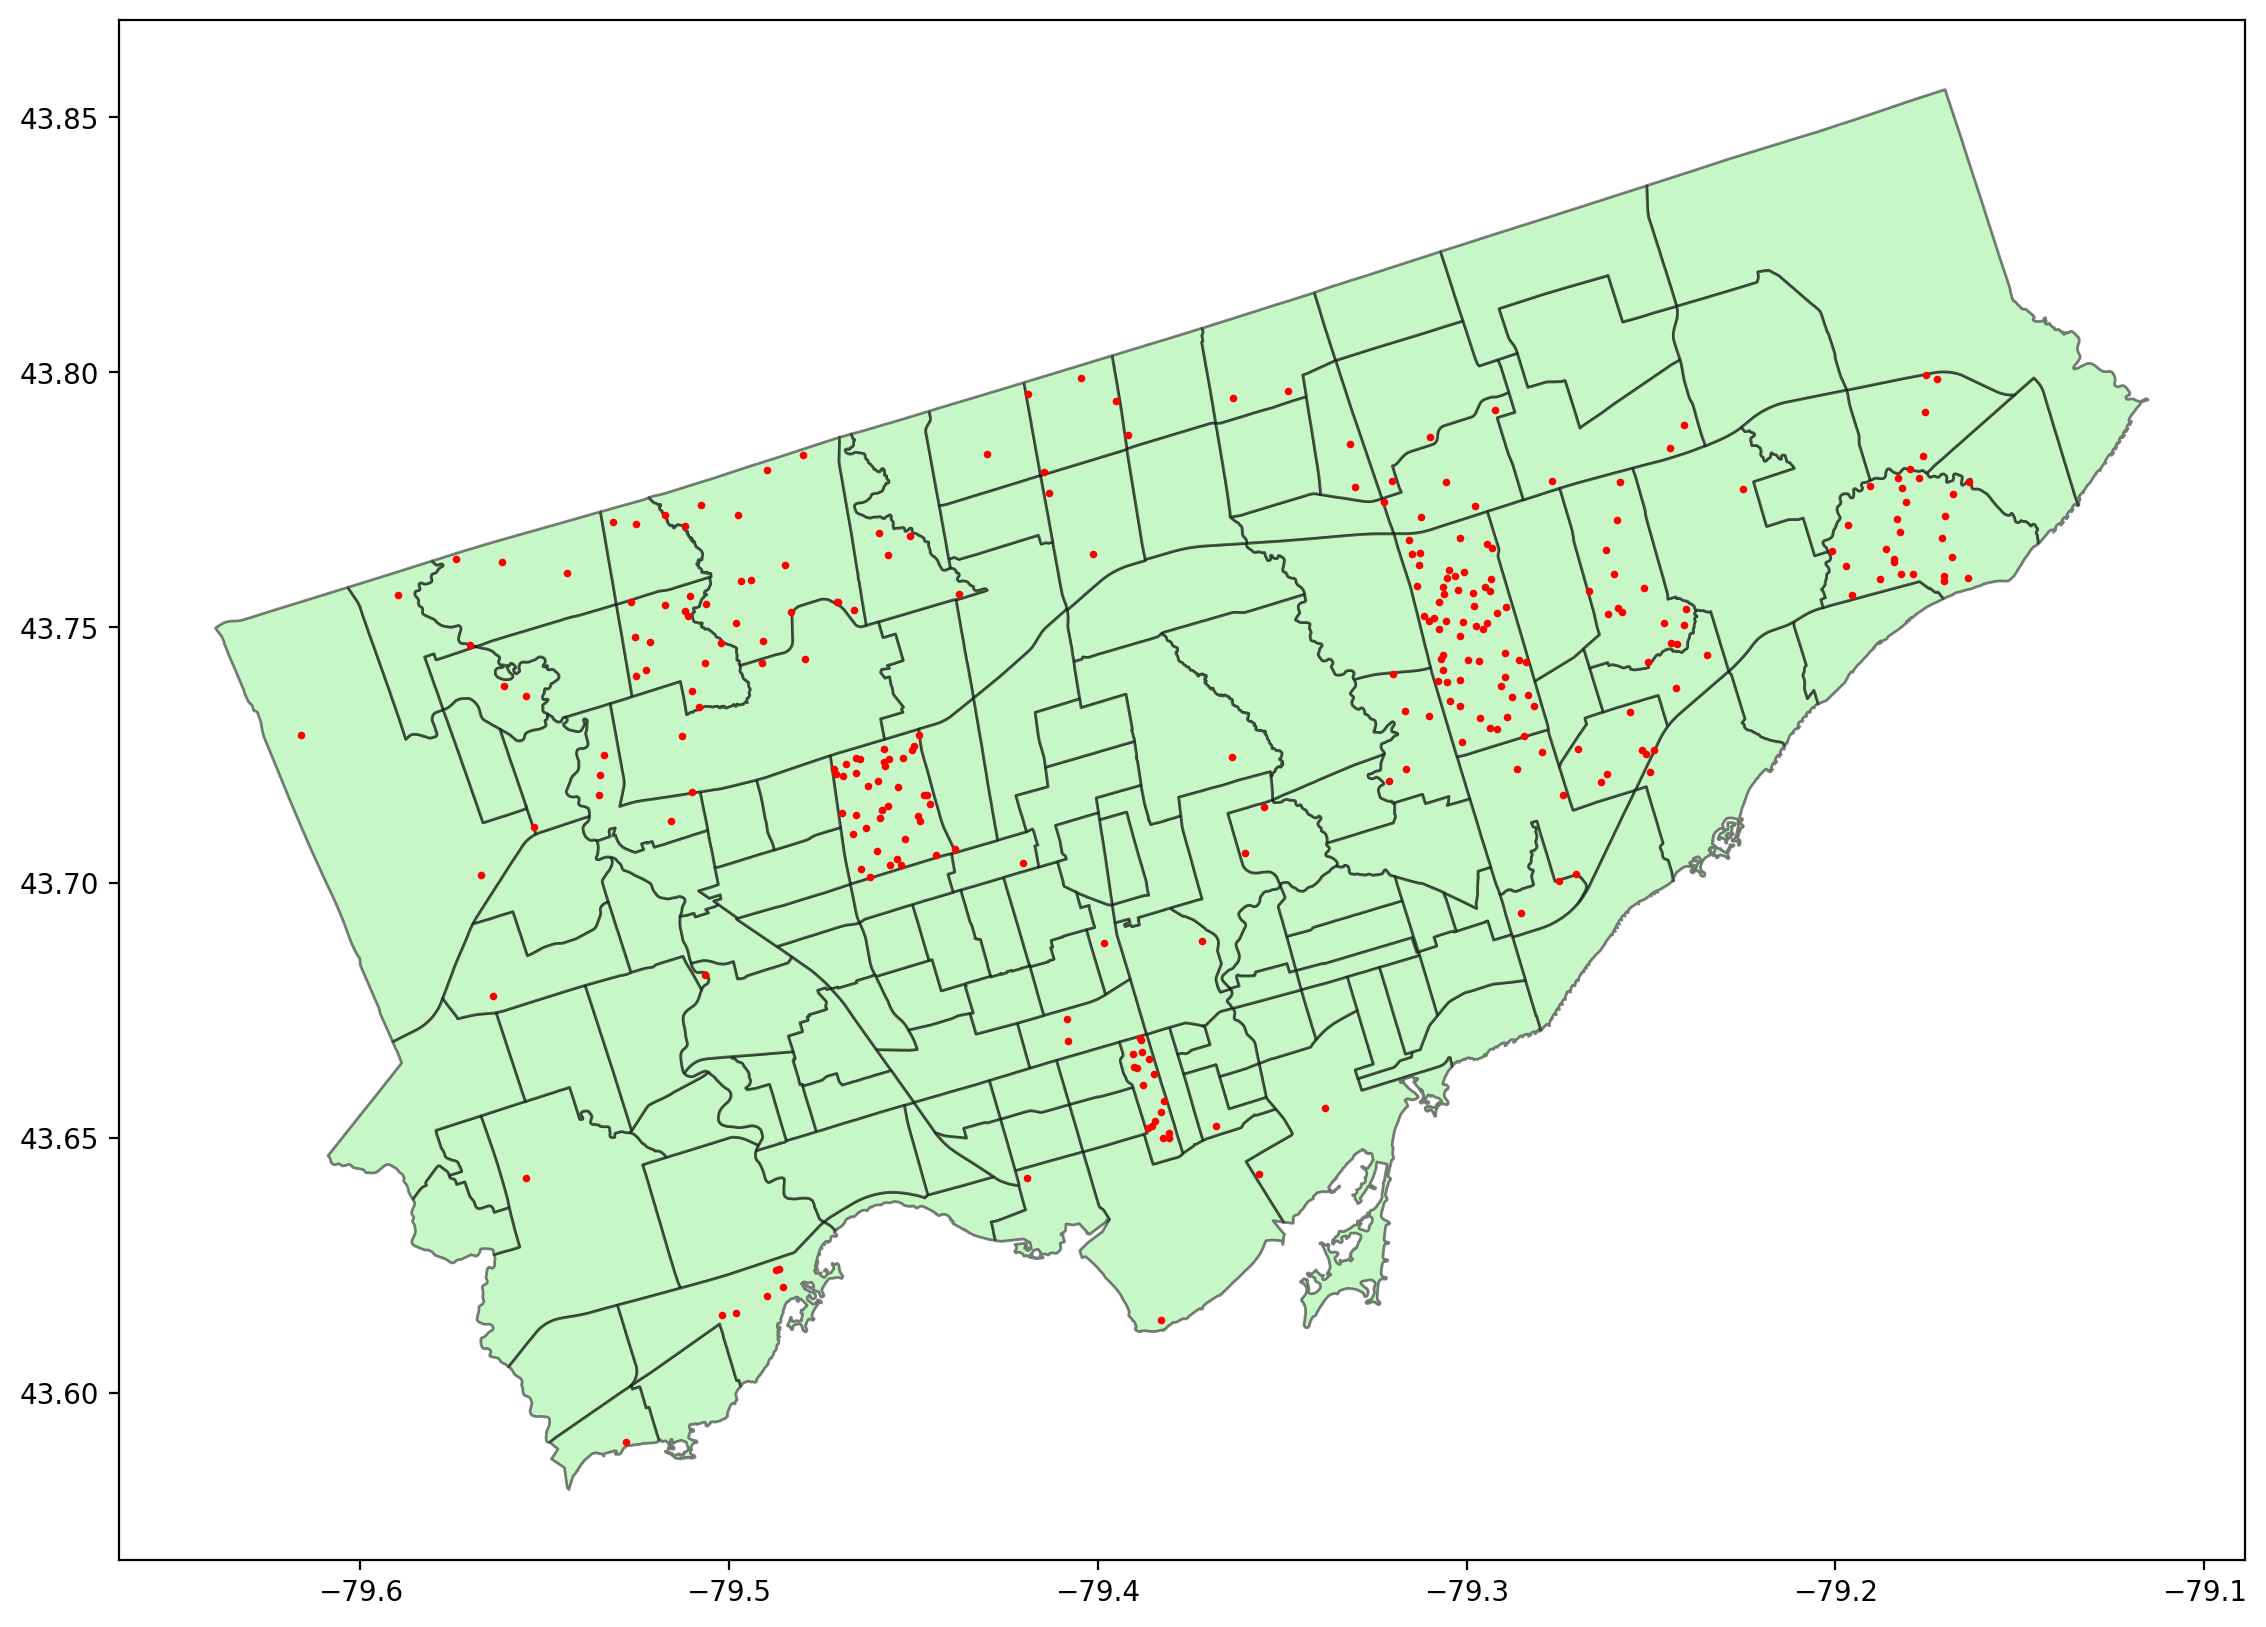

In [77]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

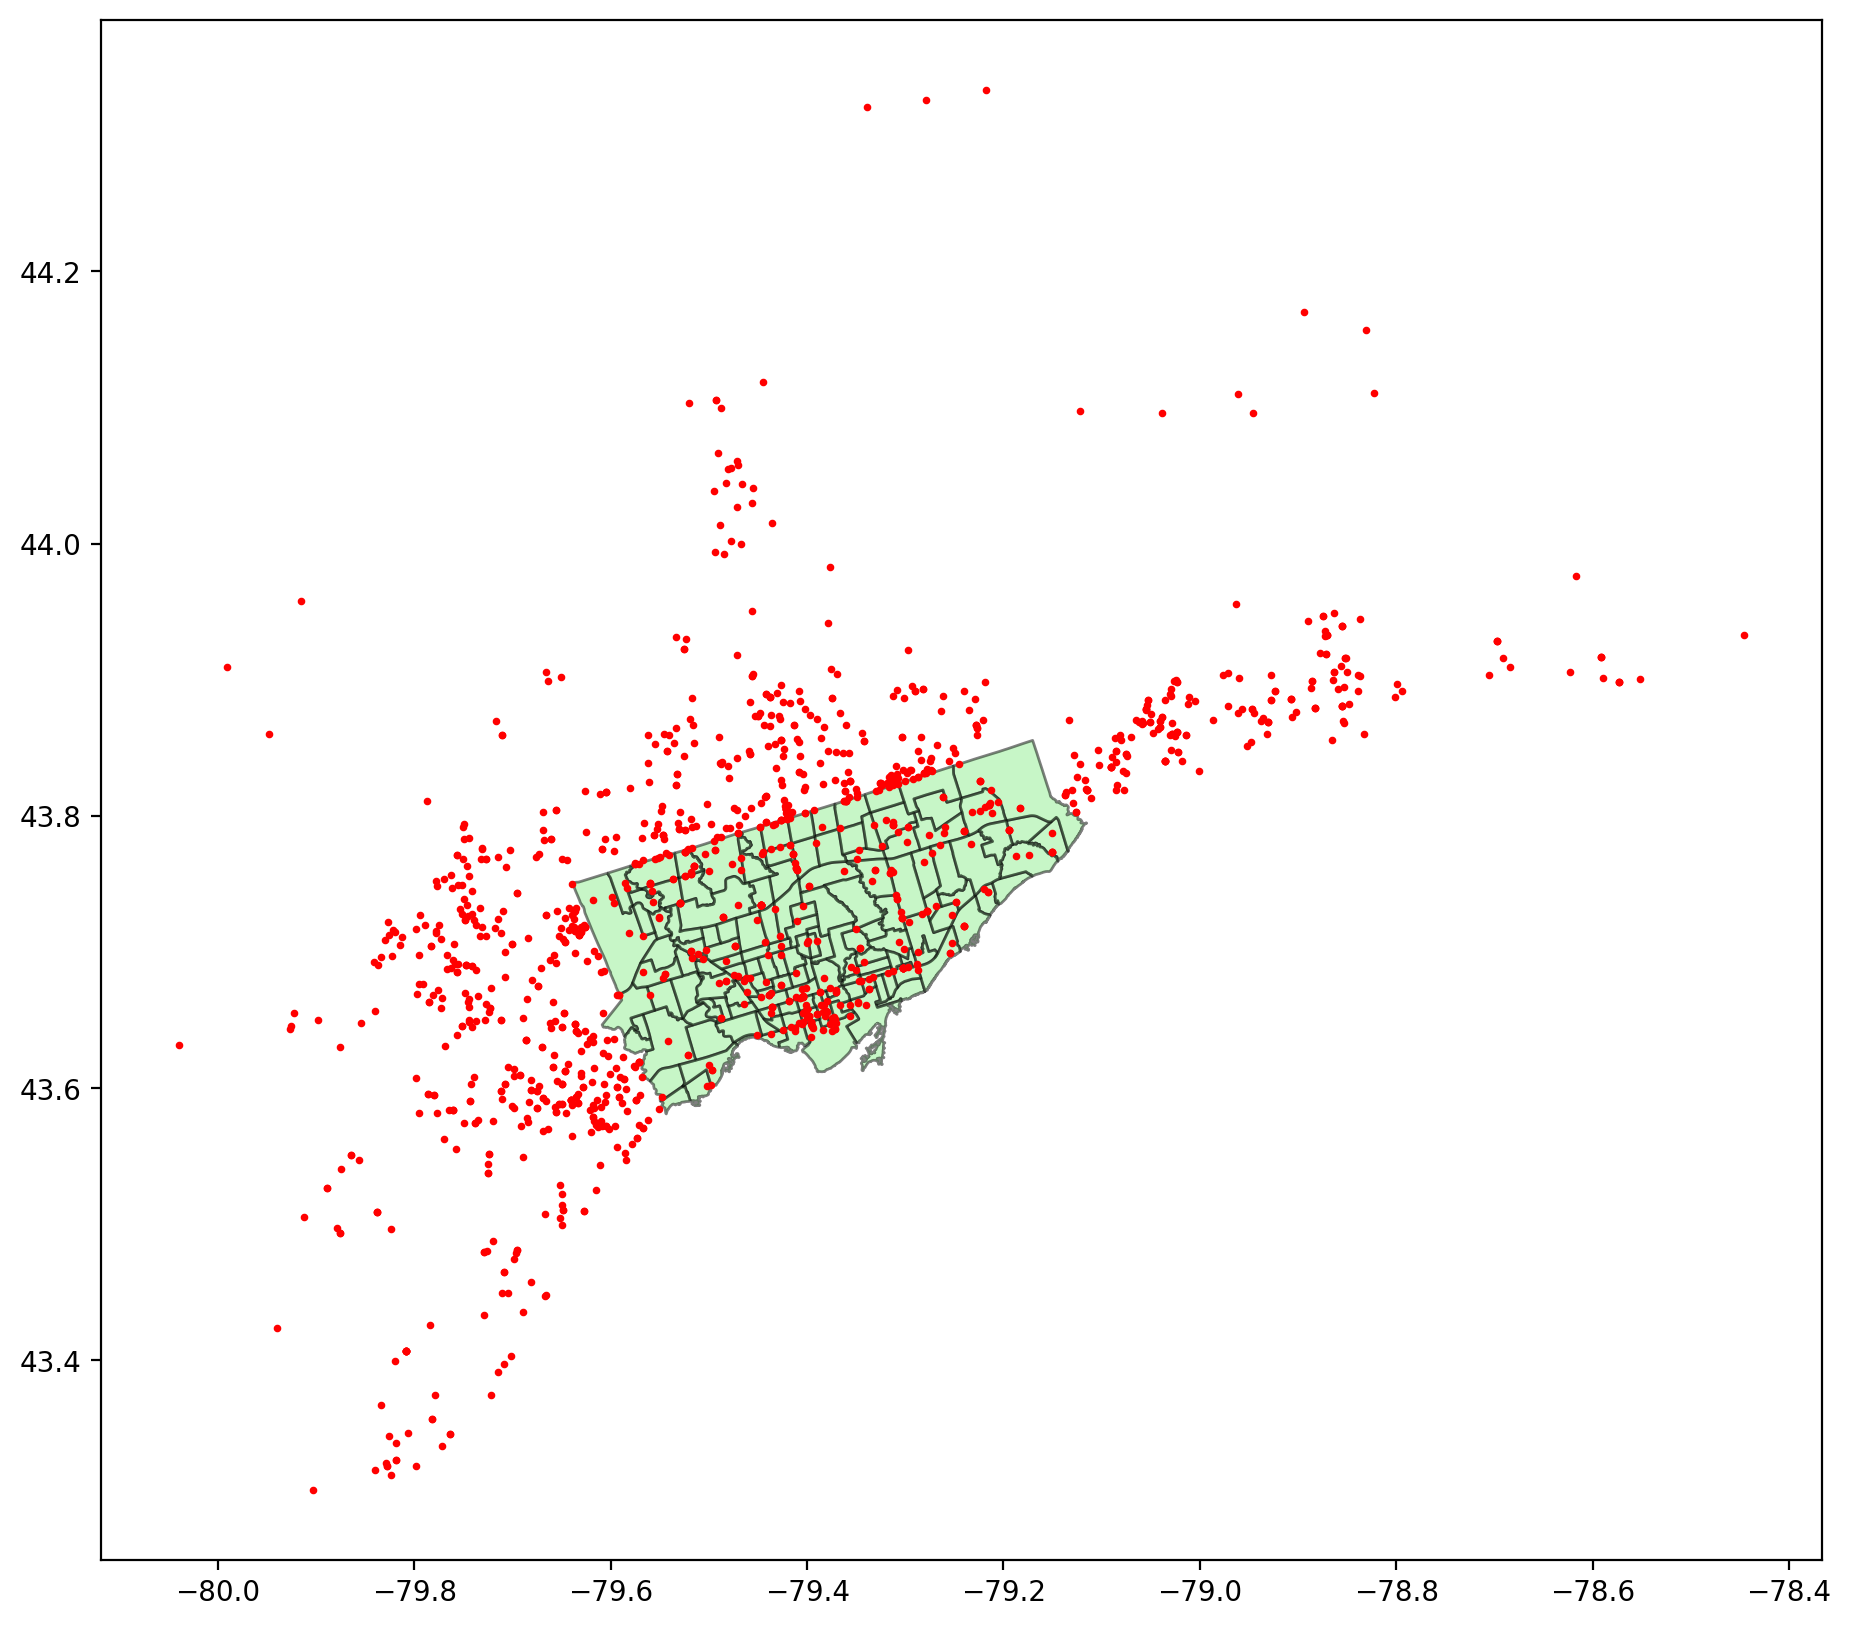

In [78]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [79]:
# get the points contained within the neighbourhoods
NSA_within_neighbourhood = gpd.sjoin(mci_point[mci_point['Neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighbourhood.index, ['Hood_ID', 'Neighbourhood']] = NSA_within_neighbourhood[['Hood_ID_right', 'Neighbourhood_right']].values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

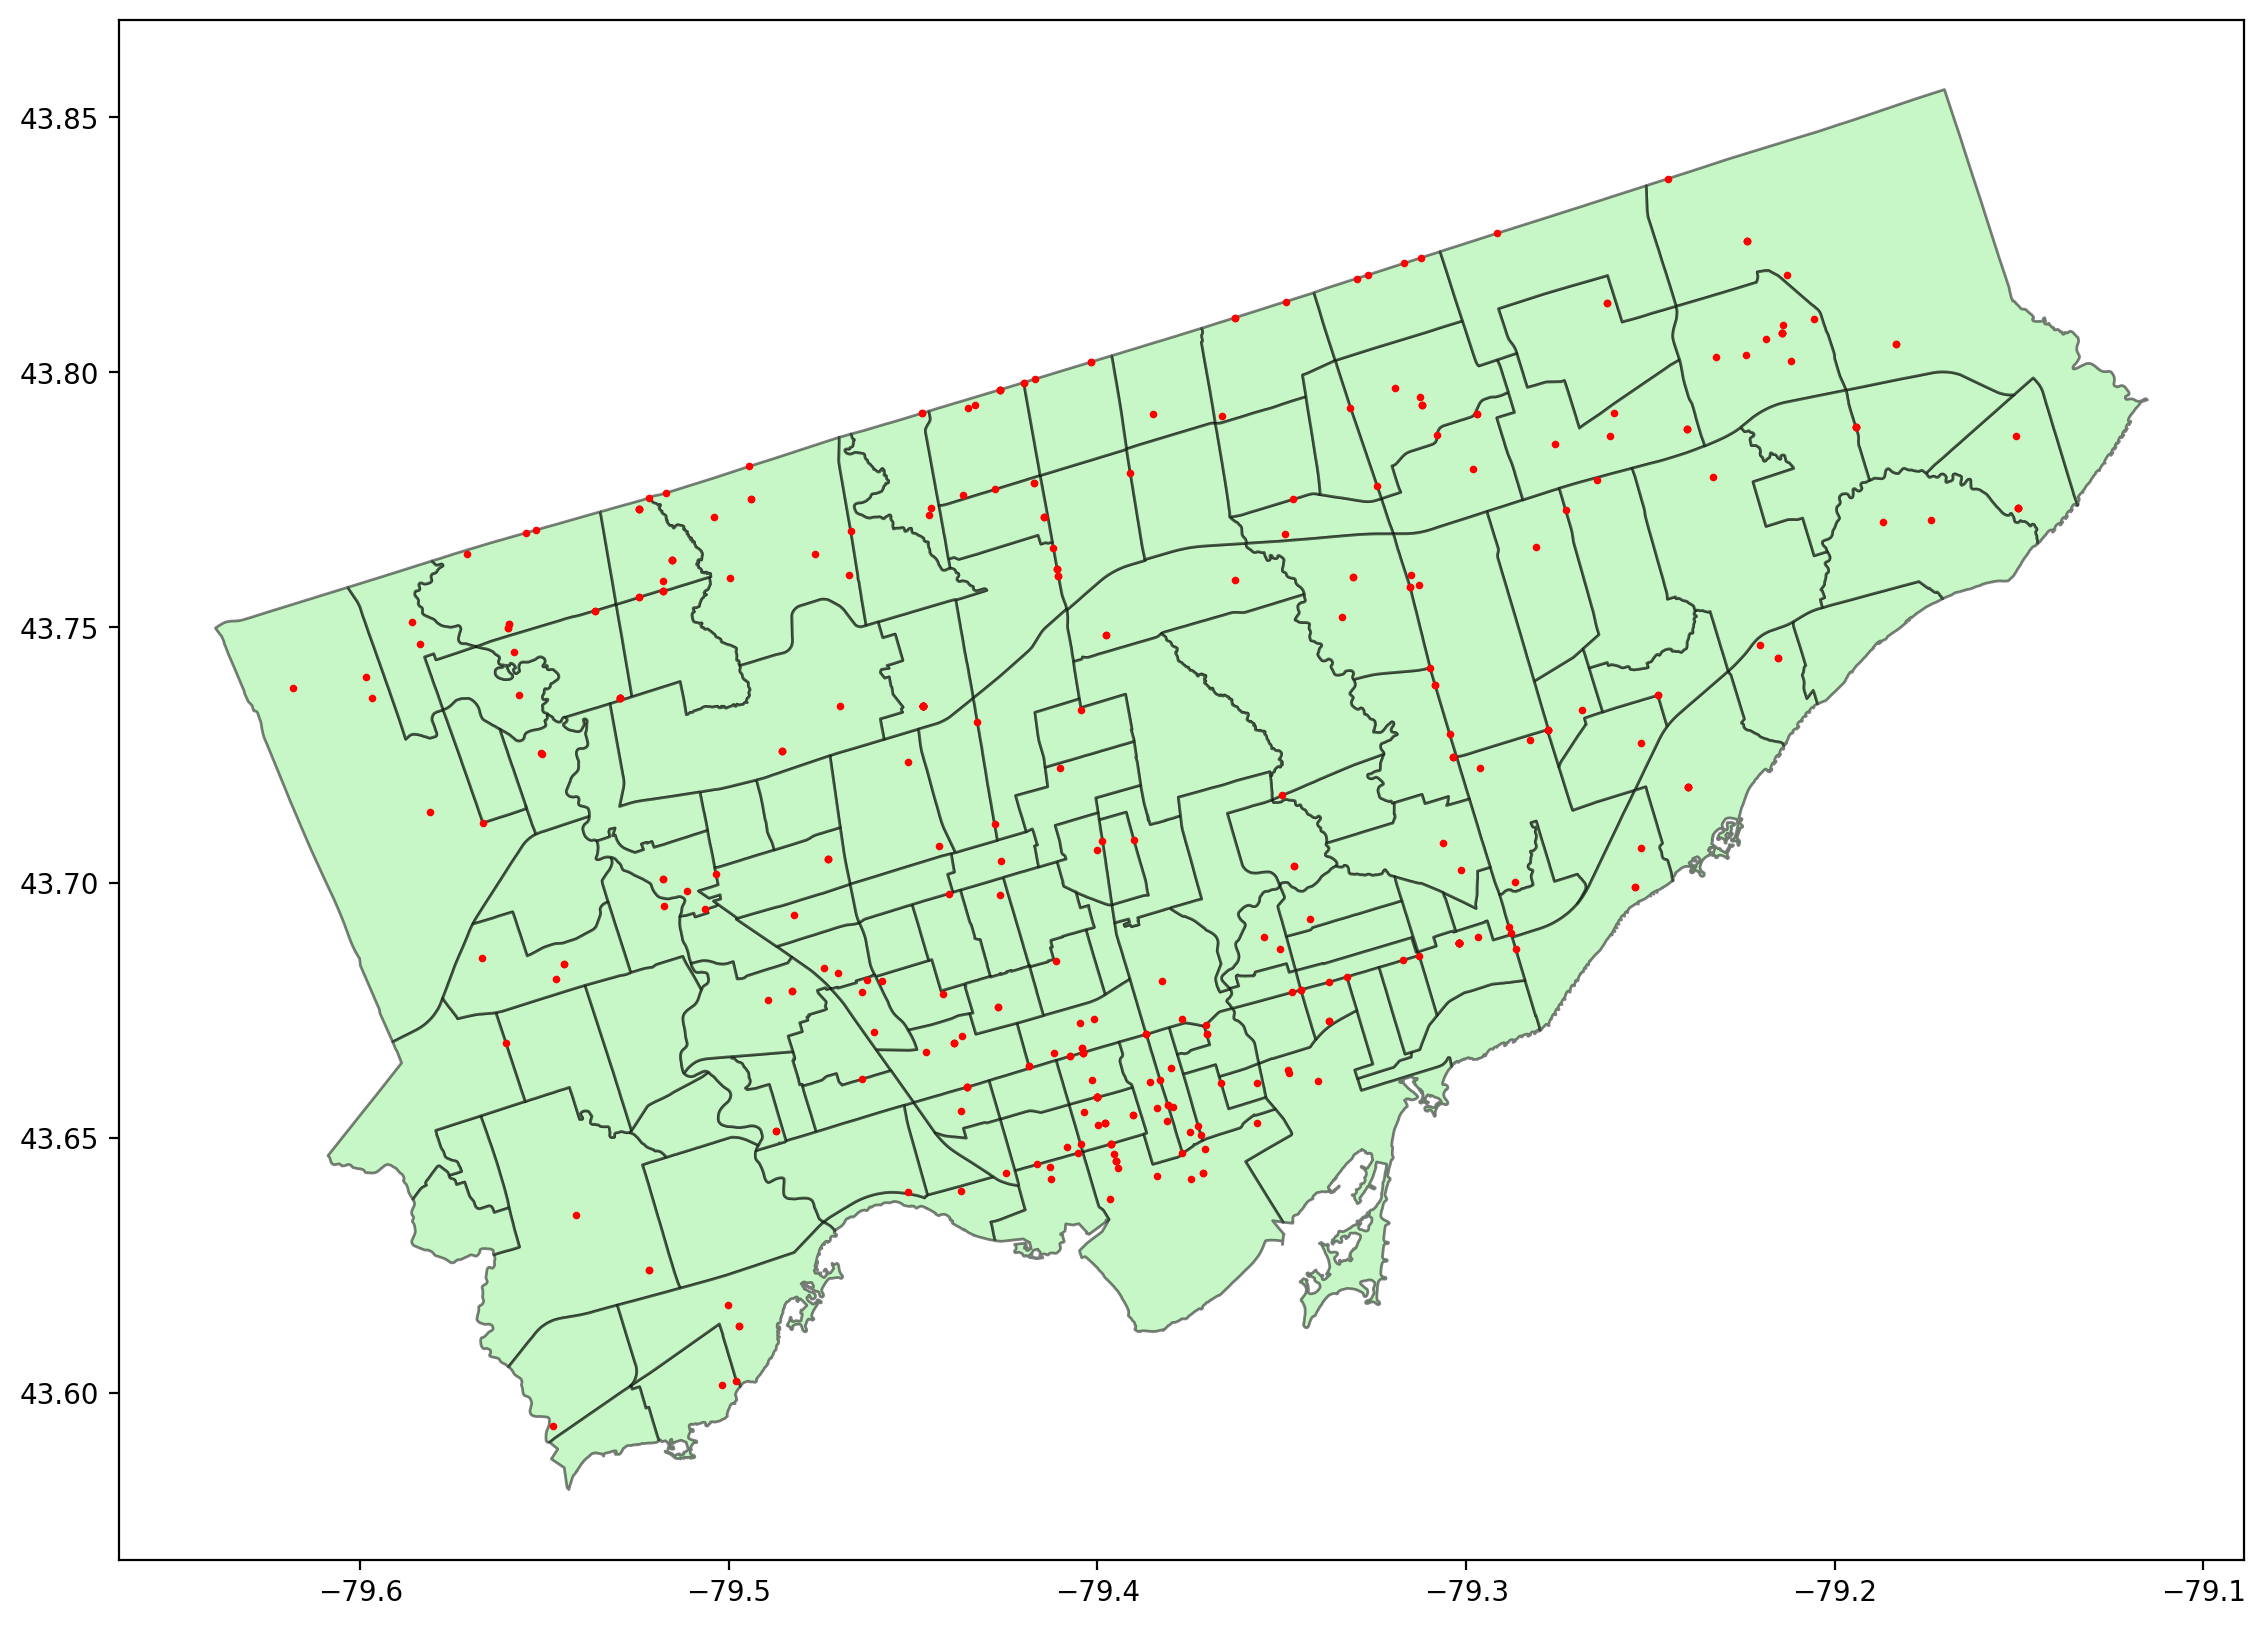

In [80]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

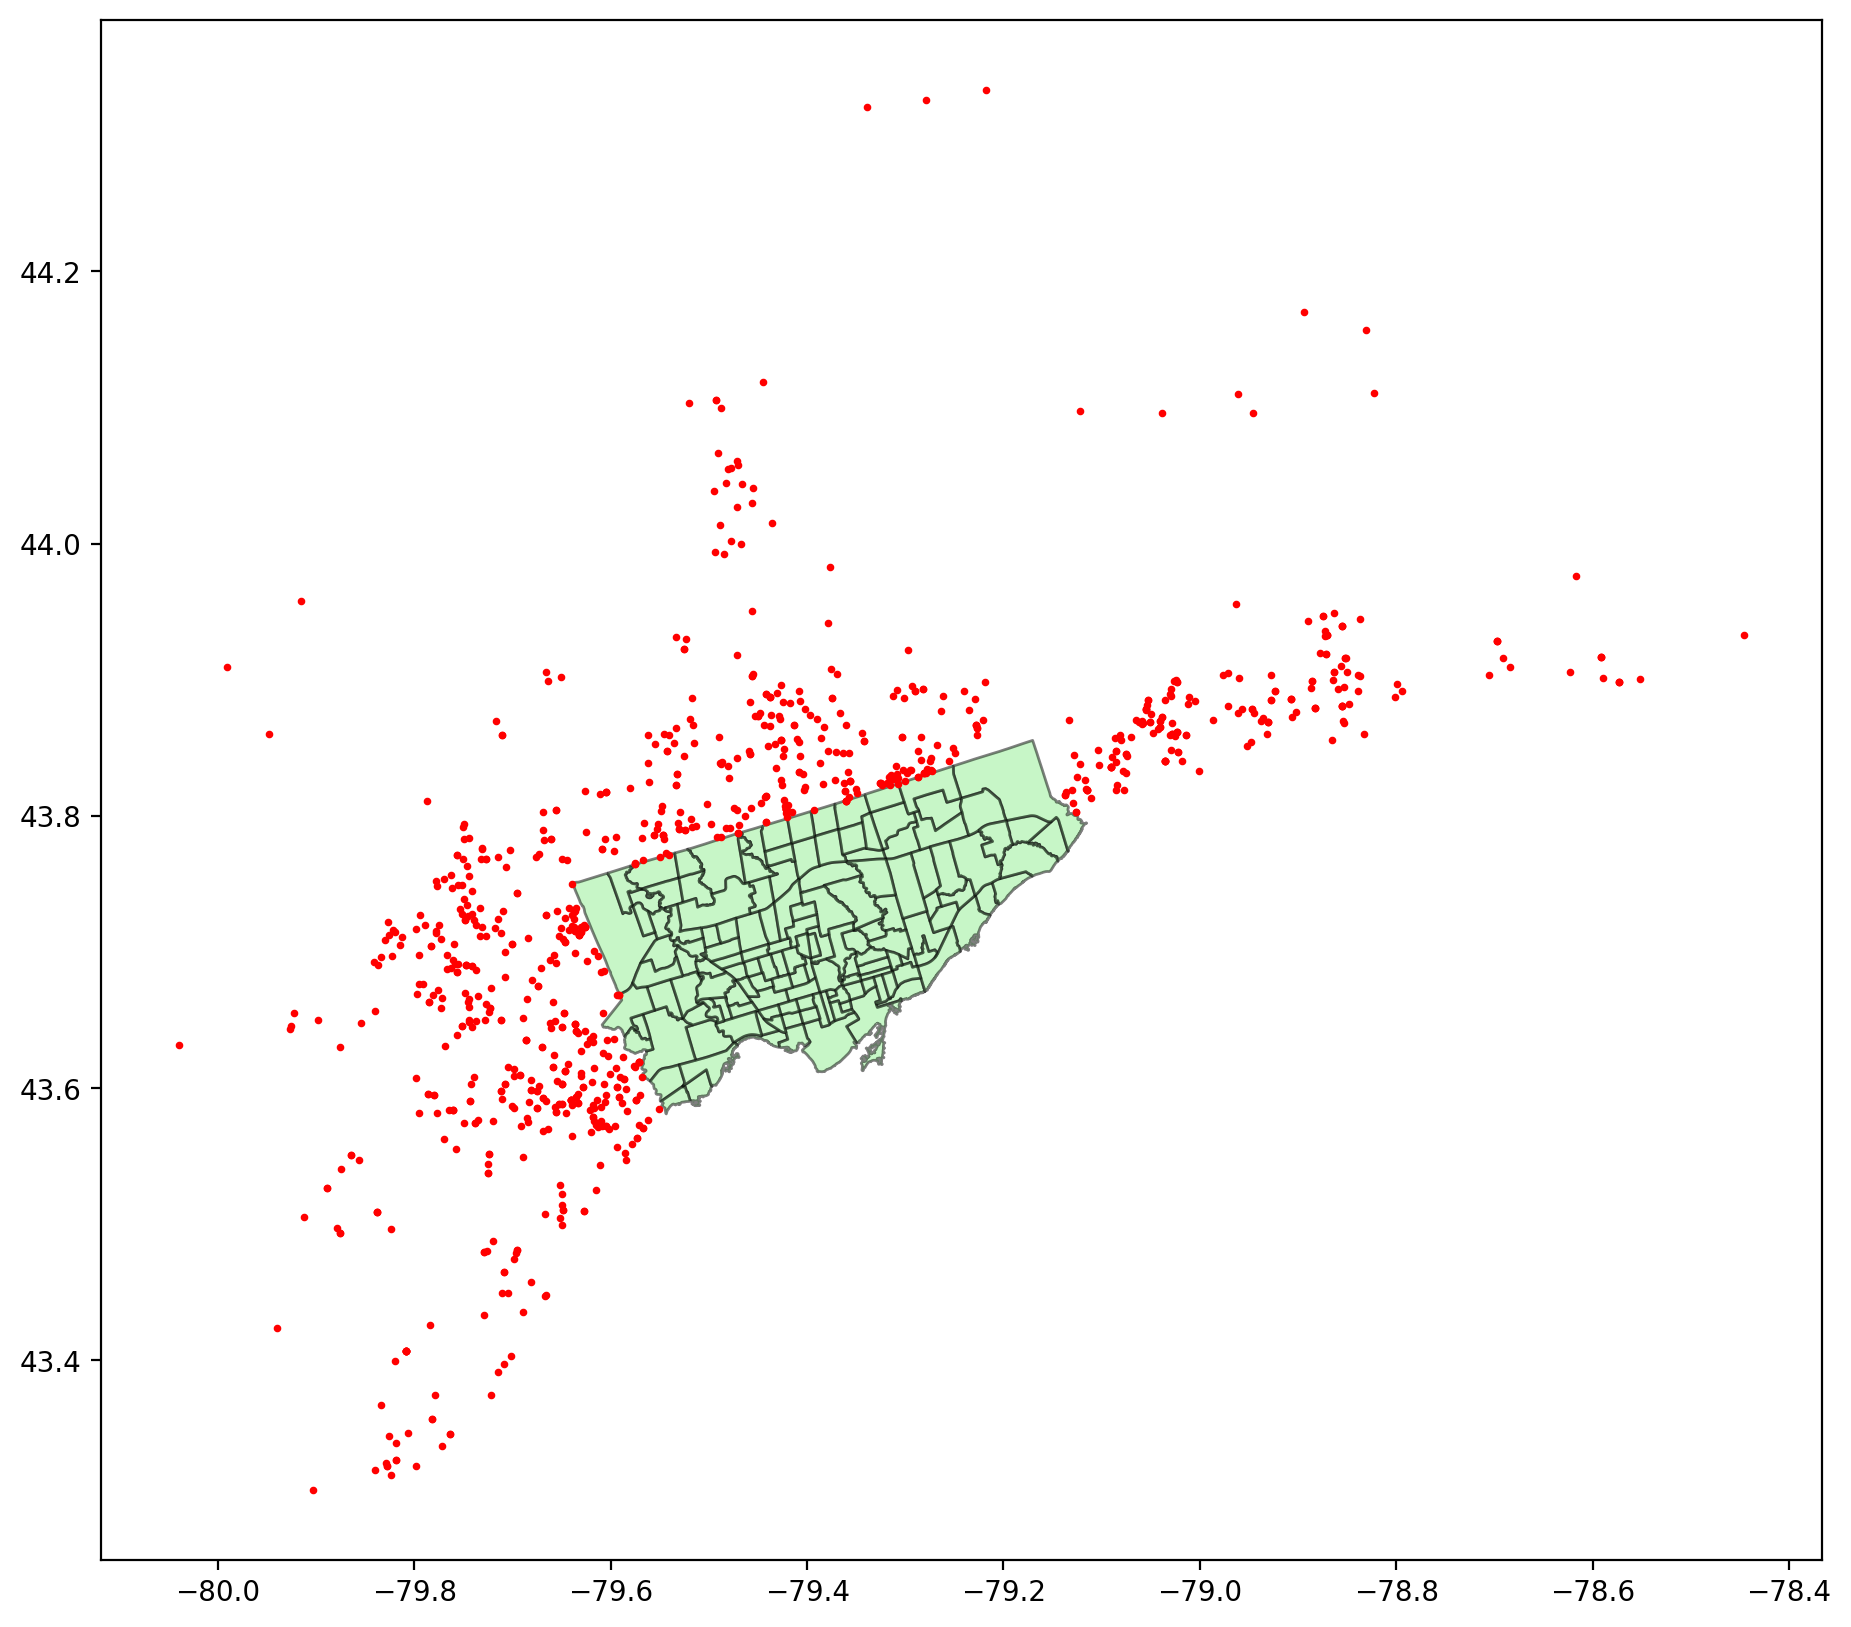

In [81]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
# no red dots should be inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

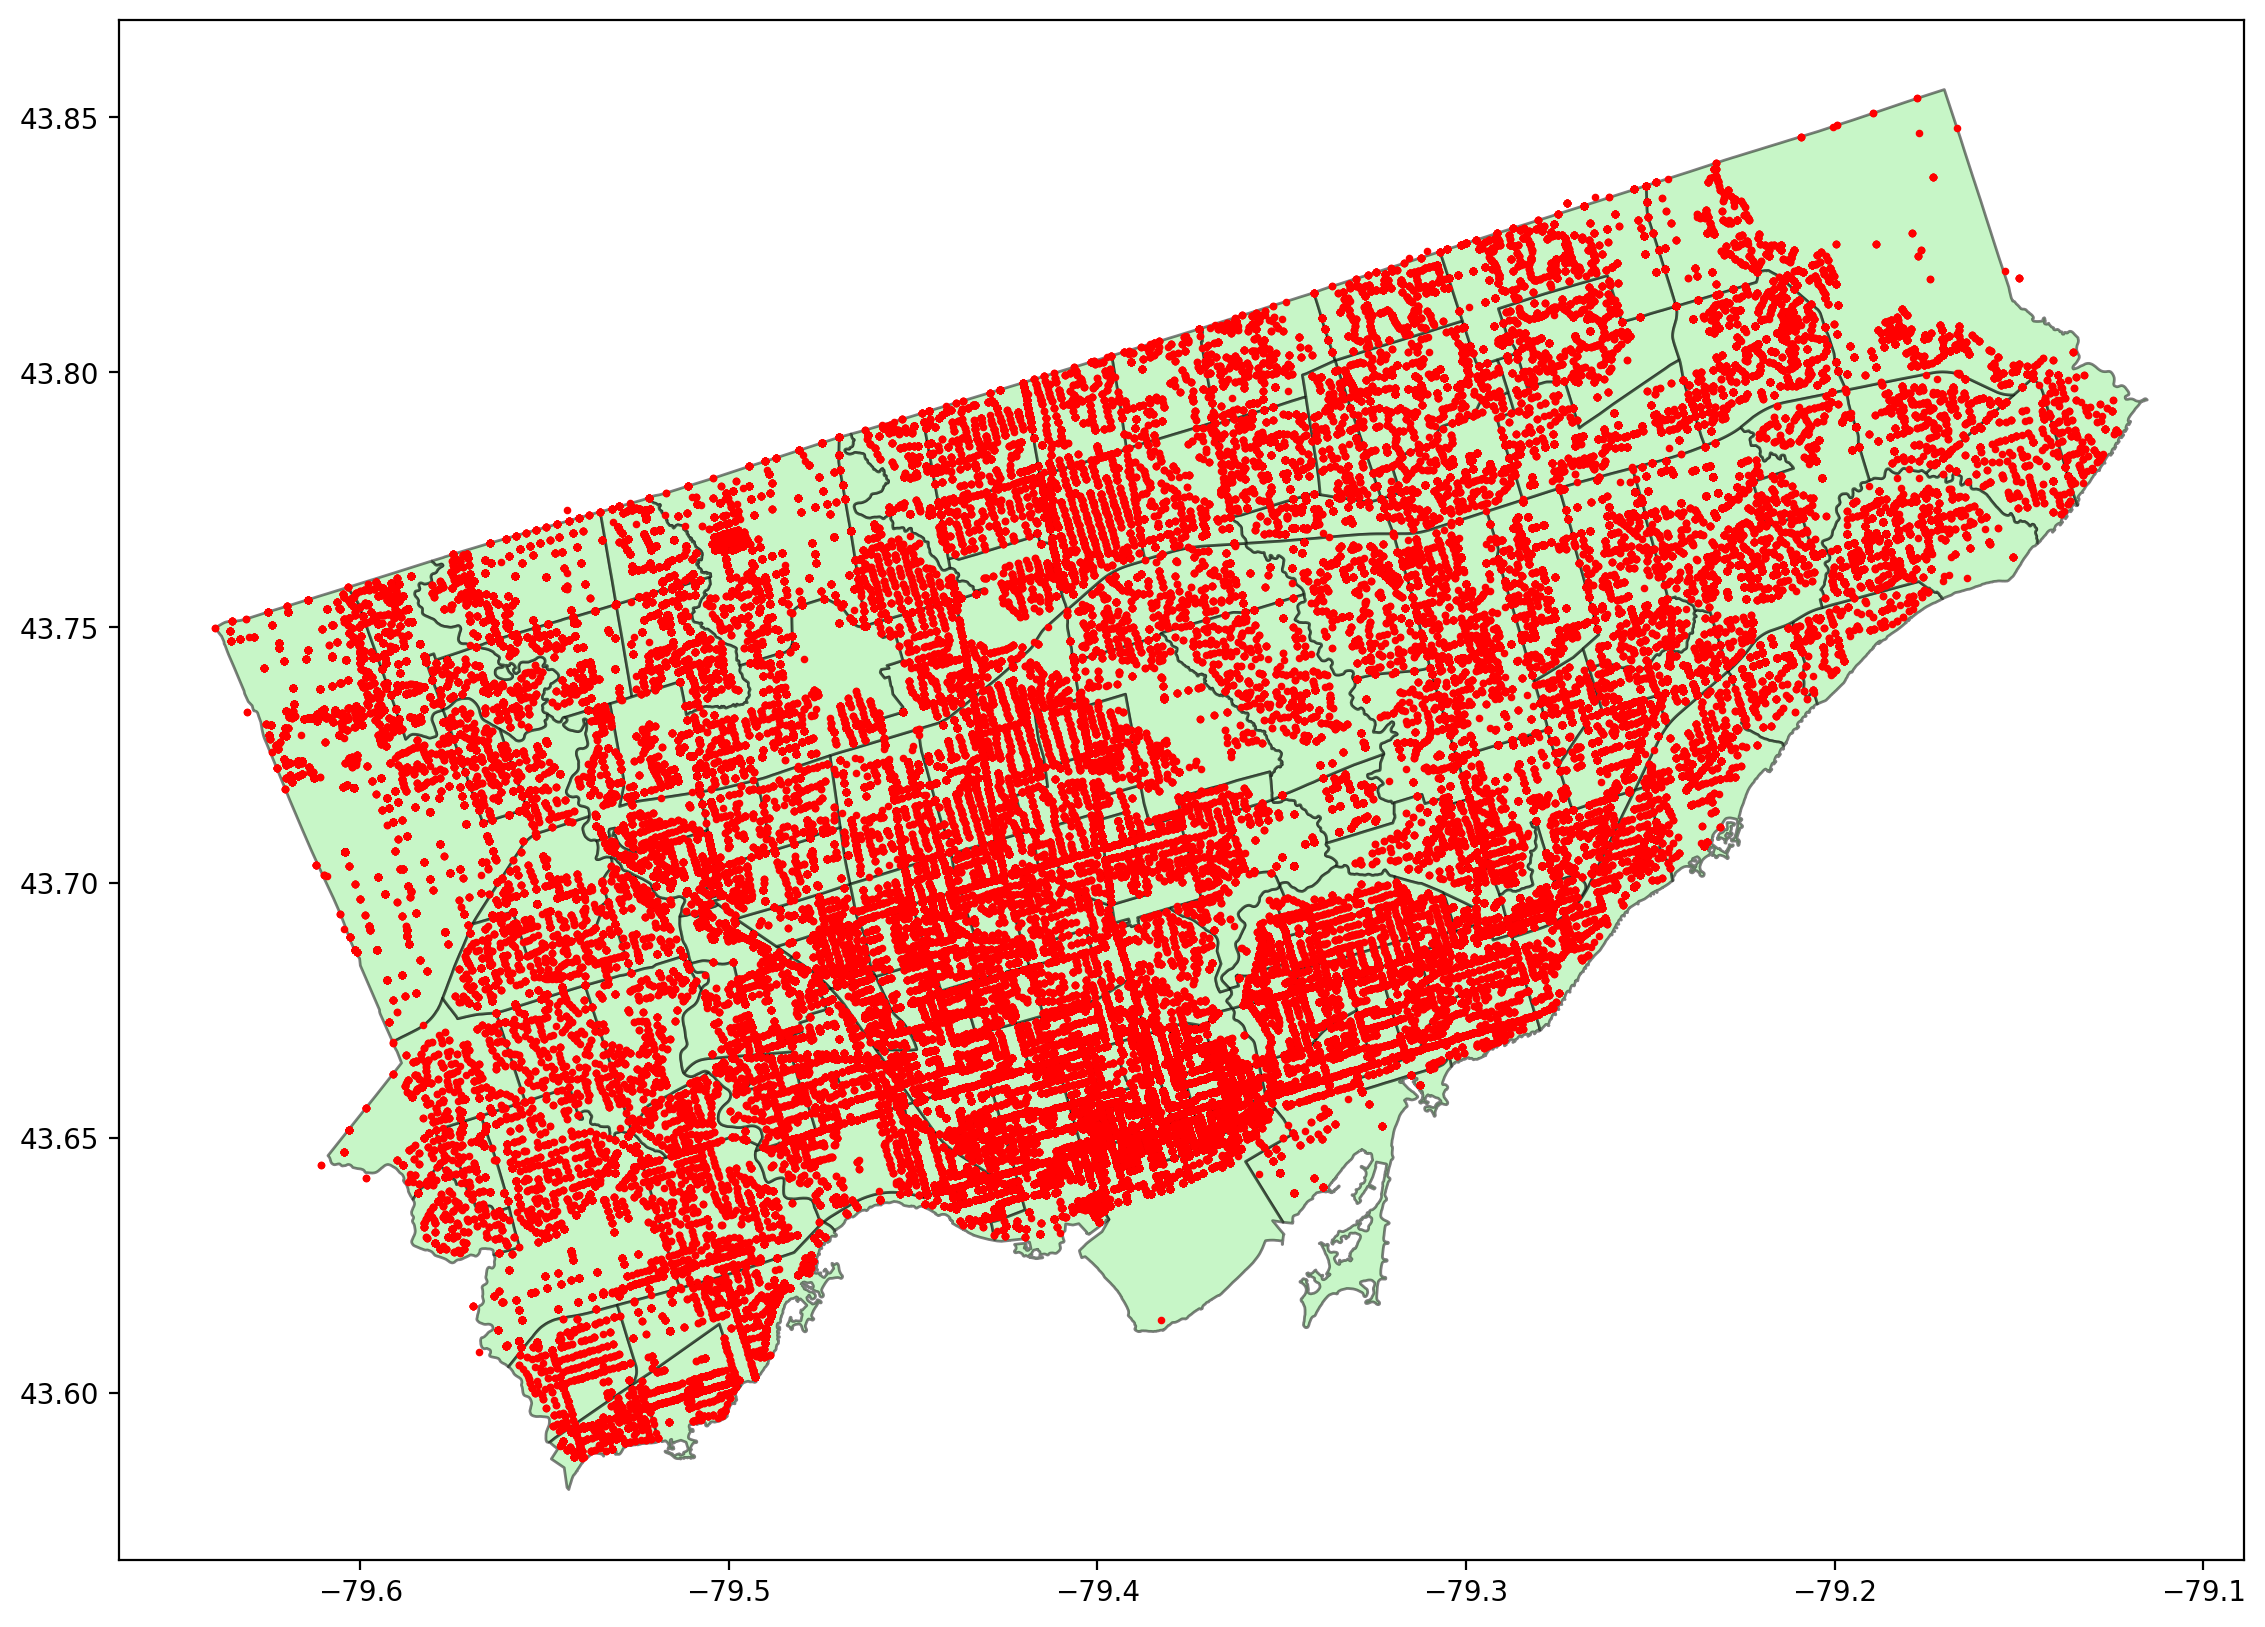

In [82]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Output

In [83]:
mci_point

X             Y  Index_ event_unique_id Division  \
0      -8.859955e+06  5.424372e+06     110  GO-20141625305      D23   
1      -8.861110e+06  5.424036e+06     188  GO-20141272968      D23   
2      -8.861120e+06  5.417043e+06     287  GO-20141284361      D23   
3      -8.861463e+06  5.425856e+06     384  GO-20141292177      D23   
4      -8.859522e+06  5.418688e+06     438  GO-20141297201      D23   
...              ...           ...     ...             ...      ...   
284866 -8.859224e+06  5.426345e+06    1366   GO-2020898005      D23   
284867 -8.830322e+06  5.431112e+06    1367   GO-2020915335      D42   
284868 -8.822707e+06  5.425298e+06    1368   GO-2020909524      D41   
284869 -8.837879e+06  5.410726e+06    1369   GO-2020971451      D52   
284870 -8.860228e+06  5.425153e+06    1370   GO-2020993900      D23   

                  occurrencedate  occurrenceyear occurrencemonth  \
0      2014-03-02 05:00:00+00:00            2014           March   
1      2013-12-24 05:00:00+00:00            2013        December   
2      2013-01-05 05:00:00+00:00            2013         January   
3      2013-12-31 05:00:00+00:00            2013        December   
4      2014-01-03 05:00:00+00:00            2014         January   
...                          ...             ...             ...   
284866 2020-05-14 04:00:00+00:00            2020             May   
284867 2020-05-17 04:00:00+00:00            2020             May   
284868 2020-05-19 04:00:00+00:00            2020             May   
284869 2020-05-26 04:00:00+00:00            2020             May   
284870 2020-05-30 04:00:00+00:00            2020             May   

        occurrenceday  occurrencedayofyear occurrencedayofweek  \
0                   2                   61              Sunday   
1                  24                  358             Tuesday   
2                   5                    5            Saturday   
3                  31                  365             Tuesday   
4                   3                    3              Friday   
...               ...                  ...                 ...   
284866             14                  135            Thursday   
284867             17                  138              Sunday   
284868             19                  140             Tuesday   
284869             26                  147             Tuesday   
284870             30                  151            Saturday   

                    MCI Hood_ID                      Neighbourhood       Long  \
0               Assault       1             West Humber-Clairville -79.590332   
1               Robbery       1             West Humber-Clairville -79.600701   
2               Assault       1             West Humber-Clairville -79.600794   
3       Break and Enter       1             West Humber-Clairville -79.603876   
4       Break and Enter       1             West Humber-Clairville -79.586443   
...                 ...     ...                                ...        ...   
284866         Homicide       2  Mount Olive-Silverstone-Jamestown -79.583768   
284867         Homicide      46                      Pleasant View -79.324129   
284868         Homicide     138                      Eglinton East -79.255724   
284869         Homicide      77  Waterfront Communities-The Island -79.392021   
284870         Homicide       1             West Humber-Clairville -79.592783   

              Lat  ObjectId                    geometry  
0       43.734013         1  POINT (-79.59033 43.73401)  
1       43.731834         2  POINT (-79.60070 43.73183)  
2       43.686423         3  POINT (-79.60079 43.68642)  
3       43.743642         4  POINT (-79.60388 43.74364)  
4       43.697108         5  POINT (-79.58644 43.69711)  
...           ...       ...                         ...  
284866  43.746816      1248  POINT (-79.58377 43.74682)  
284867  43.777743      1249  POINT (-79.32413 43.77774)  
284868  43.740025      1250  POINT (-79.25572 43.74002)  
284

<AxesSubplot:xlabel='occurrenceyear'>

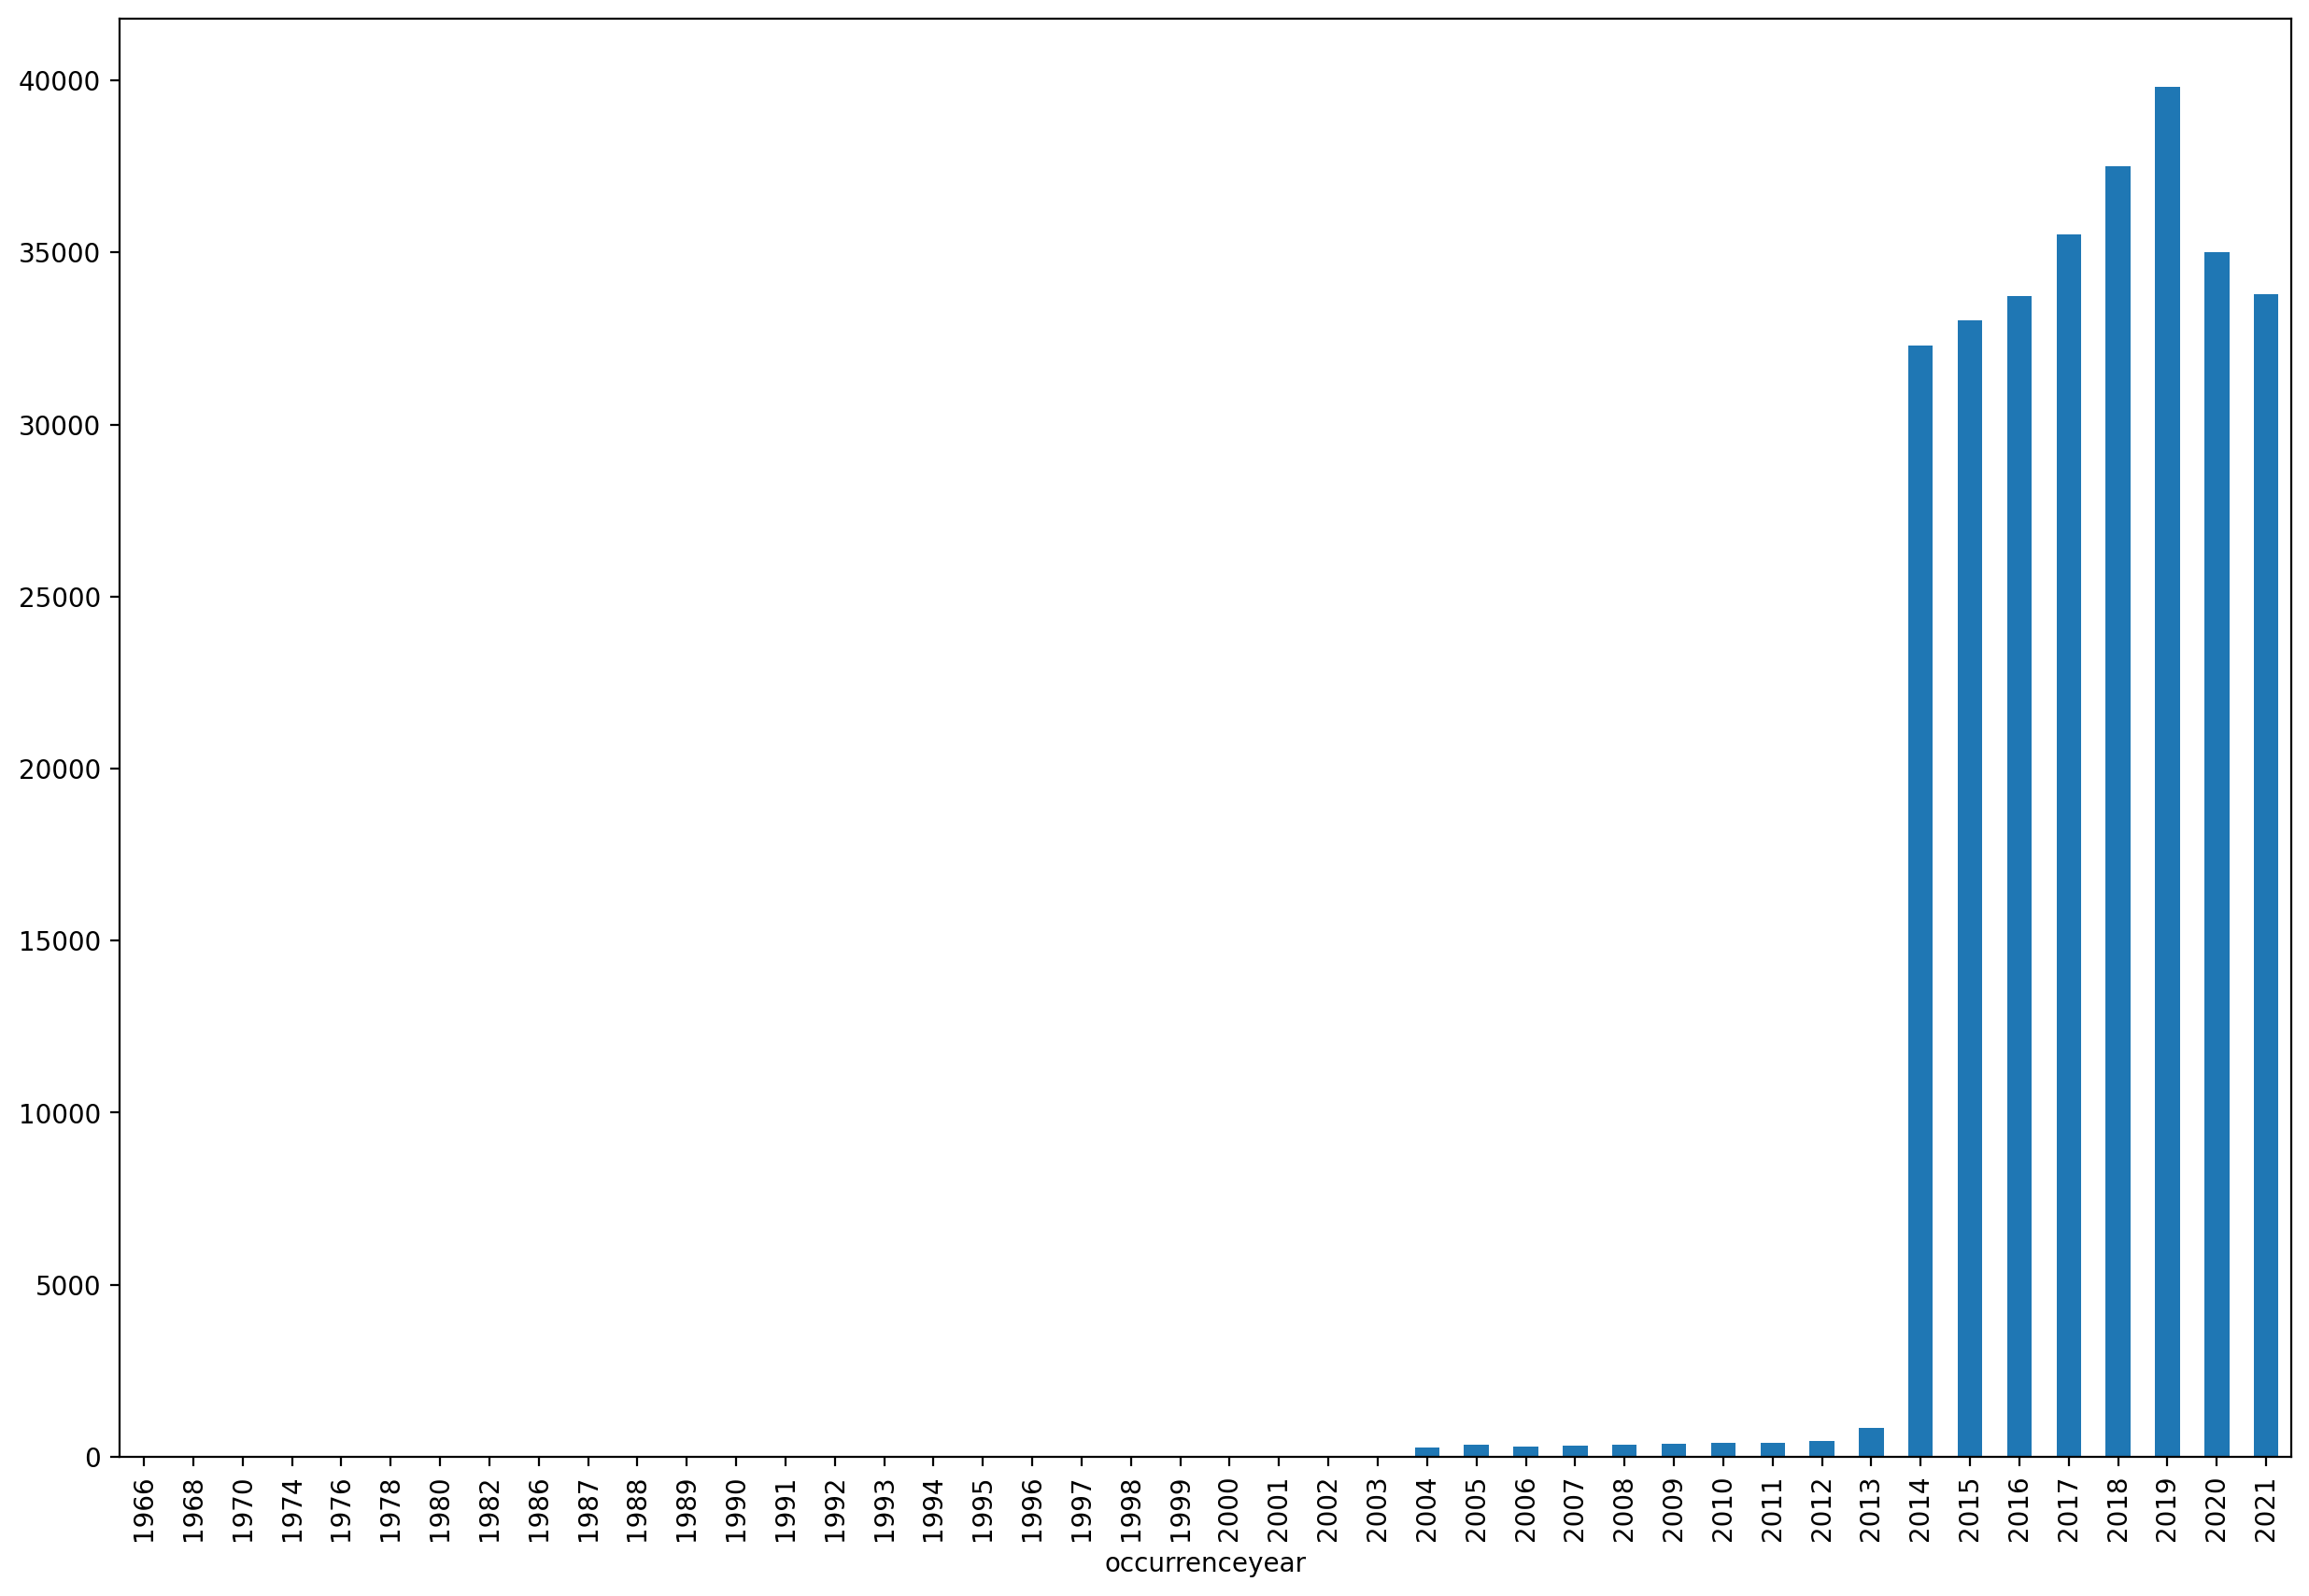

In [84]:
# There is limited data for crimes which happened before 2014
mci_point.groupby("occurrenceyear").size().plot(kind="bar")

In [85]:
mci_select = mci_point[mci_point['occurrenceyear'] >= 2014]

In [110]:
# output file to clean_data folder
# csv instead of geojson due to size
mci_select.to_csv('./clean_data/mci_select.csv', index=False)

# Aggregate crimes by neighbourhood after 2014

In [112]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
mci_groupby = mci_point[(mci_point.Neighbourhood != "NSA") & (mci_point.occurrenceyear >= 2014)].groupby(["Neighbourhood", "Hood_ID", "occurrenceyear", "MCI"]).size().reset_index(name="count")
mci_groupby

Neighbourhood Hood_ID  occurrenceyear              MCI  count
0        Agincourt North     129            2014          Assault     78
1        Agincourt North     129            2014       Auto Theft     19
2        Agincourt North     129            2014  Break and Enter     45
3        Agincourt North     129            2014          Robbery     34
4        Agincourt North     129            2014       Theft Over      1
...                  ...     ...             ...              ...    ...
6691  Yorkdale-Glen Park      31            2021  Break and Enter     66
6692  Yorkdale-Glen Park      31            2021         Homicide      1
6693  Yorkdale-Glen Park      31            2021          Robbery     17
6694  Yorkdale-Glen Park      31            2021        Shootings      9
6695  Yorkdale-Glen Park      31            2021       Theft Over     21

[6696 rows x 5 columns]

In [113]:
mci_groupby.occurrenceyear.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [114]:
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhood_years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [115]:
neighbourhoods_select = neighbourhoods[['Neighbourhood', 'Hood_ID'] + 
                                       ['Population_' + x for x in neighbourhood_years] + 
                                       ['geometry']]

In [116]:
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhoods_select['Population_2021'] = (neighbourhoods_select['Population_2020'] * neighbourhoods_select['Population_2020'] / neighbourhoods_select['Population_2019']).values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [117]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_10976\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [118]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='Population', 
                                        i=['Neighbourhood', 'Hood_ID'], 
                                        j='occurrenceyear', sep='_').reset_index()
neighbourhoods_select

Neighbourhood Hood_ID  occurrenceyear      area  \
0                          Yonge-St.Clair      97            2014  1.161318   
1                          Yonge-St.Clair      97            2015  1.161318   
2                          Yonge-St.Clair      97            2016  1.161318   
3                          Yonge-St.Clair      97            2017  1.161318   
4                          Yonge-St.Clair      97            2018  1.161318   
...                                   ...     ...             ...       ...   
1115  Mimico (includes Humber Bay Shores)      17            2017  7.059185   
1116  Mimico (includes Humber Bay Shores)      17            2018  7.059185   
1117  Mimico (includes Humber Bay Shores)      17            2019  7.059185   
1118  Mimico (includes Humber Bay Shores)      17            2020  7.059185   
1119  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

        Population  
0     12597.000000  
1     12746.000000  
2     12950.000000  
3     13214.000000  
4     13508.000000  
...            ...  
1115  36043.000000  
1116  31671.000000  
1117  37839.000000  
1118  38738.000000  
1119  39658.358942  

[1120 rows x 5 columns]

In [119]:
mci_groupby

Neighbourhood Hood_ID  occurrenceyear              MCI  count
0        Agincourt North     129            2014          Assault     78
1        Agincourt North     129            2014       Auto Theft     19
2        Agincourt North     129            2014  Break and Enter     45
3        Agincourt North     129            2014          Robbery     34
4        Agincourt North     129            2014       Theft Over      1
...                  ...     ...             ...              ...    ...
6691  Yorkdale-Glen Park      31            2021  Break and Enter     66
6692  Yorkdale-Glen Park      31            2021         Homicide      1
6693  Yorkdale-Glen Park      31            2021          Robbery     17
6694  Yorkdale-Glen Park      31            2021        Shootings      9
6695  Yorkdale-Glen Park      31            2021       Theft Over     21

[6696 rows x 5 columns]

In [120]:
neighbourhood_crime_merge = neighbourhoods_select.merge(mci_groupby, how='outer', on=['Neighbourhood', 'Hood_ID', 'occurrenceyear'])
neighbourhood_crime_merge

Neighbourhood Hood_ID  occurrenceyear      area  \
0                          Yonge-St.Clair      97            2014  1.161318   
1                          Yonge-St.Clair      97            2014  1.161318   
2                          Yonge-St.Clair      97            2014  1.161318   
3                          Yonge-St.Clair      97            2014  1.161318   
4                          Yonge-St.Clair      97            2014  1.161318   
...                                   ...     ...             ...       ...   
6691  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
6692  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
6693  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
6694  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
6695  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

        Population              MCI  count  
0     12597.000000          Assault     18  
1     12597.000000       Auto Theft      2  
2     12597.000000  Break and Enter     37  
3     12597.000000          Robbery      4  
4     12597.000000       Theft Over      2  
...            ...              ...    ...  
6691  39658.358942       Auto Theft     55  
6692  39658.358942  Break and Enter     52  
6693  39658.358942          Robbery     13  
6694  39658.358942        Shootings      3  
6695  39658.358942       Theft Over     12  

[6696 rows x 7 columns]

In [121]:
neighbourhood_crime_merge.isna().sum()

Neighbourhood     0
Hood_ID           0
occurrenceyear    0
area              0
Population        0
MCI               0
count             0
dtype: int64

In [123]:
neighbourhood_crime_merge.MCI.unique()

array(['Assault', 'Auto Theft', 'Break and Enter', 'Robbery',
       'Theft Over', 'Shootings', 'Homicide'], dtype=object)

In [126]:
MCI_types = ['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']
neighbourhood_crime_all = neighbourhood_crime_merge[neighbourhood_crime_merge['MCI'].isin(MCI_types)].groupby(['Neighbourhood', 'Hood_ID', 'occurrenceyear', 'area', 'Population'])[['count']].sum().reset_index()
neighbourhood_crime_all["MCI"] = "MCI"

In [127]:
neighbourhood_crime_concat = pd.concat([neighbourhood_crime_merge, neighbourhood_crime_all], axis=0)
neighbourhood_crime_concat

Neighbourhood Hood_ID  occurrenceyear      area    Population  \
0         Yonge-St.Clair      97            2014  1.161318  12597.000000   
1         Yonge-St.Clair      97            2014  1.161318  12597.000000   
2         Yonge-St.Clair      97            2014  1.161318  12597.000000   
3         Yonge-St.Clair      97            2014  1.161318  12597.000000   
4         Yonge-St.Clair      97            2014  1.161318  12597.000000   
...                  ...     ...             ...       ...           ...   
1115  Yorkdale-Glen Park      31            2017  6.038389  15797.000000   
1116  Yorkdale-Glen Park      31            2018  6.038389  18722.000000   
1117  Yorkdale-Glen Park      31            2019  6.038389  16970.000000   
1118  Yorkdale-Glen Park      31            2020  6.038389  17560.000000   
1119  Yorkdale-Glen Park      31            2021  6.038389  18170.512669   

                  MCI  count  
0             Assault     18  
1          Auto Theft      2  
2     Break and Enter     37  
3             Robbery      4  
4          Theft Over      2  
...               ...    ...  
1115              MCI    338  
1116              MCI    373  
1117              MCI    440  
1118              MCI    378  
1119              MCI    355  

[7816 rows x 7 columns]

In [128]:
# rate: number of crimes per 100k people
neighbourhood_crime_concat['rate'] = neighbourhood_crime_concat['count'] / neighbourhood_crime_concat['Population'] * 10**5
# density: number of crimes per 1km^2
neighbourhood_crime_concat['density'] = neighbourhood_crime_concat['count'] / neighbourhood_crime_concat['area']

In [129]:
neighbourhood_crime_concat

Neighbourhood Hood_ID  occurrenceyear      area    Population  \
0         Yonge-St.Clair      97            2014  1.161318  12597.000000   
1         Yonge-St.Clair      97            2014  1.161318  12597.000000   
2         Yonge-St.Clair      97            2014  1.161318  12597.000000   
3         Yonge-St.Clair      97            2014  1.161318  12597.000000   
4         Yonge-St.Clair      97            2014  1.161318  12597.000000   
...                  ...     ...             ...       ...           ...   
1115  Yorkdale-Glen Park      31            2017  6.038389  15797.000000   
1116  Yorkdale-Glen Park      31            2018  6.038389  18722.000000   
1117  Yorkdale-Glen Park      31            2019  6.038389  16970.000000   
1118  Yorkdale-Glen Park      31            2020  6.038389  17560.000000   
1119  Yorkdale-Glen Park      31            2021  6.038389  18170.512669   

                  MCI  count         rate    density  
0             Assault     18   142.891165  15.499636  
1          Auto Theft      2    15.876796   1.722182  
2     Break and Enter     37   293.720727  31.860363  
3             Robbery      4    31.753592   3.444364  
4          Theft Over      2    15.876796   1.722182  
...               ...    ...          ...        ...  
1115              MCI    338  2139.646768  55.975198  
1116              MCI    373  1992.308514  61.771447  
1117              MCI    440  2592.810843  72.867122  
1118              MCI    378  2152.619590  62.599482  
1119              MCI    355  1953.714826  58.790519  

[7816 rows x 9 columns]

In [152]:
neighbourhood_crime_melt = neighbourhood_crime_concat.melt(id_vars=['Neighbourhood', 'Hood_ID', 'occurrenceyear', 'area', 'Population', 'MCI'],
                                                           value_vars=['count', 'rate', 'density'],
                                                           var_name='type',
                                                           value_name='value')
neighbourhood_crime_melt['MCI_Typeyear'] = neighbourhood_crime_melt['MCI'].astype(str).apply(lambda x: x.replace(' ', '')) + "_" + neighbourhood_crime_melt['type'].str.title() + neighbourhood_crime_melt['occurrenceyear'].astype(str)
neighbourhood_crime_melt

Neighbourhood Hood_ID  occurrenceyear      area    Population  \
0          Yonge-St.Clair      97            2014  1.161318  12597.000000   
1          Yonge-St.Clair      97            2014  1.161318  12597.000000   
2          Yonge-St.Clair      97            2014  1.161318  12597.000000   
3          Yonge-St.Clair      97            2014  1.161318  12597.000000   
4          Yonge-St.Clair      97            2014  1.161318  12597.000000   
...                   ...     ...             ...       ...           ...   
23443  Yorkdale-Glen Park      31            2017  6.038389  15797.000000   
23444  Yorkdale-Glen Park      31            2018  6.038389  18722.000000   
23445  Yorkdale-Glen Park      31            2019  6.038389  16970.000000   
23446  Yorkdale-Glen Park      31            2020  6.038389  17560.000000   
23447  Yorkdale-Glen Park      31            2021  6.038389  18170.512669   

                   MCI     type      value             MCI_Typeyear  
0              Assault    count  18.000000        Assault_Count2014  
1           Auto Theft    count   2.000000      AutoTheft_Count2014  
2      Break and Enter    count  37.000000  BreakandEnter_Count2014  
3              Robbery    count   4.000000        Robbery_Count2014  
4           Theft Over    count   2.000000      TheftOver_Count2014  
...                ...      ...        ...                      ...  
23443              MCI  density  55.975198          MCI_Density2017  
23444              MCI  density  61.771447          MCI_Density2018  
23445              MCI  density  72.867122          MCI_Density2019  
23446              MCI  density  62.599482          MCI_Density2020  
23447              MCI  density  58.790519          MCI_Density2021  

[23448 rows x 9 columns]

In [153]:
neighbourhood_crime_pivot = neighbourhood_crime_melt.pivot(index=['Neighbourhood', 'Hood_ID'], columns=['MCI_Typeyear'], values=['value'])
neighbourhood_crime_pivot

value                    \
MCI_Typeyear                         Assault_Count2014 Assault_Count2015   
Neighbourhood                Hood_ID                                       
Agincourt North              129                  78.0              69.0   
Agincourt South-Malvern West 128                 106.0              98.0   
Alderwood                    20                   47.0              46.0   
Annex                        95                  243.0             264.0   
Banbury-Don Mills            42                   61.0              74.0   
...                                                ...               ...   
Wychwood                     94                   54.0              74.0   
Yonge-Eglinton               100                  58.0              67.0   
Yonge-St.Clair               97                   18.0              24.0   
York University Heights      27                  271.0             294.0   
Yorkdale-Glen Park           31                  105.0             133.0   

                                                                          \
MCI_Typeyear                         Assault_Count2016 Assault_Count2017   
Neighbourhood                Hood_ID                                       
Agincourt North              129                  78.0              73.0   
Agincourt South-Malvern West 128                 143.0             109.0   
Alderwood                    20                   39.0              24.0   
Annex                        95                  282.0             275.0   
Banbury-Don Mills            42                   88.0             112.0   
...                                                ...               ...   
Wychwood                     94                   79.0              54.0   
Yonge-Eglinton               100                  63.0              68.0   
Yonge-St.Clair               97                   35.0              25.0   
York University Heights      27                  363.0             359.0   
Yorkdale-Glen Park           31                  179.0             164.0   

                                                                          \
MCI_Typeyear                         Assault_Count2018 Assault_Count2019   
Neighbourhood                Hood_ID                                       
Agincourt North              129                  81.0              80.0   
Agincourt South-Malvern West 128                 113.0             114.0   
Alderwood                    20                   27.0              36.0   
Annex                        95                  272.0             322.0   
Banbury-Don Mills            42                   76.0              74.0   
...                                                ...               ...   
Wychwood                     94                   76.0              67.0   
Yonge-Eglinton               100                  67.0              92.0   
Yonge-St.Clair               97                   33.0              33.0   
York University Heights      27                  370.0             372.0   
Yorkdale-Glen Park           31                  174.0             213.0   

                                                                          \
MCI_Typeyear                         Assault_Count2020 Assault_Count2021   
Neighbourhood                Hood_ID                                       
Agincourt North              129                  65.0              60.0   
Agincourt South-Malvern West 128                 127.0             150.0   
Alderwood                    20                   34.0              27.0   
Annex                        95                  284.0             305.0   
Banbury-Don Mills            42                   83.0              82.0   
...                                                ...               ...   
Wychwood                     94                   86.0              57.0   
Yonge-Eglinton               100                  93.0              61.0   
Yonge-St.Clair    

In [154]:
neighbourhood_crime_pivot.columns = neighbourhood_crime_pivot.columns.droplevel(0)

In [155]:
neighbourhood_crime_pivot = neighbourhood_crime_pivot.reset_index()

In [156]:
neighbourhood_crime_pivot

MCI_Typeyear                 Neighbourhood Hood_ID  Assault_Count2014  \
0                          Agincourt North     129               78.0   
1             Agincourt South-Malvern West     128              106.0   
2                                Alderwood      20               47.0   
3                                    Annex      95              243.0   
4                        Banbury-Don Mills      42               61.0   
..                                     ...     ...                ...   
135                               Wychwood      94               54.0   
136                         Yonge-Eglinton     100               58.0   
137                         Yonge-St.Clair      97               18.0   
138                York University Heights      27              271.0   
139                     Yorkdale-Glen Park      31              105.0   

MCI_Typeyear  Assault_Count2015  Assault_Count2016  Assault_Count2017  \
0                          69.0               78.0               73.0   
1                          98.0              143.0              109.0   
2                          46.0               39.0               24.0   
3                         264.0              282.0              275.0   
4                          74.0               88.0              112.0   
..                          ...                ...                ...   
135                        74.0               79.0               54.0   
136                        67.0               63.0               68.0   
137                        24.0               35.0               25.0   
138                       294.0              363.0              359.0   
139                       133.0              179.0              164.0   

MCI_Typeyear  Assault_Count2018  Assault_Count2019  Assault_Count2020  \
0                          81.0               80.0               65.0   
1                         113.0              114.0              127.0   
2                          27.0               36.0               34.0   
3                         272.0              322.0              284.0   
4                          76.0               74.0               83.0   
..                          ...                ...                ...   
135                        76.0               67.0               86.0   
136                        67.0               92.0               93.0   
137                        33.0               33.0               25.0   
138                       370.0              372.0              346.0   
139                       174.0              213.0              155.0   

MCI_Typeyear  Assault_Count2021  Assault_Density2014  Assault_Density2015  \
0                          60.0            10.741104             9.501746   
1                         150.0            13.463475            12.447364   
2                          27.0             9.440516             9.239654   
3                         305.0            87.084986            94.610849   
4                          82.0             6.074863             7.369505   
..                          ...                  ...                  ...   
135                        57.0            32.101250            43.990602   
136                        61.0            35.142298            40.595413   
137                        48.0            15.499636            20.666181   
138                       327.0            20.457863            22.194140   
139                       159.0            17.388745            22.025744   

MCI_Typeyear  Assault_Density2016  Assault_Density2017  Assault_Density2018  \
0                       10.741104            10.052572            11.154224   
1                       18.162990            13.844517            14.352573   
2                        7.833619             4.820689             5.423275   
3                      101.061589            98.552968            97.477844   
4                        8.763736            11.1

In [157]:
# Missing data: number of neighbourhoods which have no data for a particular MCI type in a particular year
# same number of missing data for each type of MCI
pd.DataFrame(neighbourhood_crime_pivot.isna().sum()[neighbourhood_crime_pivot.isna().sum() != 0]).T

MCI_Typeyear  AutoTheft_Count2015  AutoTheft_Count2017  AutoTheft_Density2015  \
0                               1                    1                      1   

MCI_Typeyear  AutoTheft_Density2017  AutoTheft_Rate2015  AutoTheft_Rate2017  \
0                                 1                   1                   1   

MCI_Typeyear  Homicide_Count2014  Homicide_Count2015  Homicide_Count2016  \
0                             98                 101                  96   

MCI_Typeyear  Homicide_Count2017  Homicide_Count2018  Homicide_Count2019  \
0                            101                  85                  87   

MCI_Typeyear  Homicide_Count2020  Homicide_Count2021  Homicide_Density2014  \
0                             92                  88                    98   

MCI_Typeyear  Homicide_Density2015  Homicide_Density2016  \
0                              101                    96   

MCI_Typeyear  Homicide_Density2017  Homicide_Density2018  \
0                              101                    85   

MCI_Typeyear  Homicide_Density2019  Homicide_Density2020  \
0                               87                    92   

MCI_Typeyear  Homicide_Density2021  Homicide_Rate2014  Homicide_Rate2015  \
0                               88                 98                101   

MCI_Typeyear  Homicide_Rate2016  Homicide_Rate2017  Homicide_Rate2018  \
0                            96                101                 85   

MCI_Typeyear  Homicide_Rate2019  Homicide_Rate2020  Homicide_Rate2021  \
0                            87                 92                 88   

MCI_Typeyear  Robbery_Count2014  Robbery_Count2016  Robbery_Count2018  \
0                             1                  1                  1   

MCI_Typeyear  Robbery_Count2021  Robbery_Density2014  Robbery_Density2016  \
0                             2                    1                    1   

MCI_Typeyear  Robbery_Density2018  Robbery_Density2021  Robbery_Rate2014  \
0                               1                    2                 1   

MCI_Typeyear  Robbery_Rate2016  Robbery_Rate2018  Robbery_Rate2021  \
0                            1                 1                 2   

MCI_Typeyear  Shootings_Count2014  Shootings_Count2015  Shootings_Count2016  \
0                              65                   61                   42   

MCI_Typeyear  Shootings_Count2017  Shootings_Count2018  Shootings_Count2019  \
0                              43                   39                   26   

MCI_Typeyear  Shootings_Count2020  Shootings_Count2021  Shootings_Density2014  \
0                              40                   36                     65   

MCI_Typeyear  Shootings_Density2015  Shootings_Density2016  \
0                                61                     42   

MCI_Typeyear  Shootings_Density2017  Shootings_Density2018  \
0                                43                     39   

MCI_Typeyear  Shootings_Density2019  Shootings_Density2020  \
0                                26                     40   

MCI_Typeyear  Shootings_Density2021  Shootings_Rate2014  Shootings_Rate2015  \
0                                36                  65                  61   

MCI_Typeyear  Shootings_Rate2016  Shootings_Rate2017  Shootings_Rate2018  \
0                             42                  43                  39   

MCI_Typeyear  Shootings_Rate2019  Shootings_Rate2020  Shootings_Rate2021  \
0                             26                  40                  36   

MCI_Typeyear  TheftOver_Count2014  TheftOver_Count2015  TheftOver_Count2016  \
0                               6                    2                    8   

MCI_Typeyear  TheftOver_Count2017  TheftOver_Count2018  TheftOver_Count2019  \
0                               3                    2                    2   

MCI_Typeyear  TheftOver_Count2020  TheftOver_Count2021  TheftOver_Density2014  \
0                               3                   11                      6   

MCI_Typ

In [158]:
neighbourhood_crime = neighbourhoods[['Neighbourhood', 'Hood_ID', 'district', 'distance_km', 'geometry']].merge(neighbourhood_crime_pivot.fillna(0), how='outer', on=['Neighbourhood', 'Hood_ID'])
neighbourhood_crime

Neighbourhood Hood_ID district  distance_km  \
0                         Yonge-St.Clair      97      C02     2.791462   
1                York University Heights      27      W05    13.676191   
2                       Lansing-Westgate      38      C07    10.427749   
3                     Yorkdale-Glen Park      31      W04     7.592207   
4                    Stonegate-Queensway      16      W07     9.017845   
..                                   ...     ...      ...          ...   
135                        Pleasant View      46      C15    14.643244   
136                             Wychwood      94      C02     2.864021   
137                   Leaside-Bennington      56      C11     5.149543   
138                 Briar Hill-Belgravia     108      W04     6.111904   
139  Mimico (includes Humber Bay Shores)      17      W06     9.894878   

                                              geometry  Assault_Count2014  \
0    POLYGON ((-79.39115 43.68108, -79.39137 43.680...               18.0   
1    POLYGON ((-79.50525 43.75987, -79.50484 43.759...              271.0   
2    POLYGON ((-79.43994 43.76156, -79.44000 43.761...               41.0   
3    POLYGON ((-79.43965 43.70561, -79.44007 43.705...              105.0   
4    POLYGON ((-79.49258 43.64744, -79.49273 43.647...               90.0   
..                                                 ...                ...   
135  POLYGON ((-79.34341 43.79517, -79.34355 43.795...               32.0   
136  POLYGON ((-79.43588 43.68015, -79.43488 43.680...               54.0   
137  POLYGON ((-79.37745 43.71309, -79.37758 43.713...               39.0   
138  POLYGON ((-79.46458 43.69216, -79.46469 43.692...               80.0   
139  POLYGON ((-79.48036 43.62107, -79.48029 43.621...              206.0   

     Assault_Count2015  Assault_Count2016  Assault_Count2017  \
0                 24.0               35.0               25.0   
1                294.0              363.0              359.0   
2                 81.0               69.0               92.0   
3                133.0              179.0              164.0   
4                 72.0               78.0               99.0   
..                 ...                ...                ...   
135               46.0               54.0               55.0   
136               74.0               79.0               54.0   
137               41.0               30.0               36.0   
138               89.0               80.0               82.0   
139              207.0              242.0              346.0   

     Assault_Count2018  Assault_Count2019  Assault_Count2020  \
0                 33.0               33.0               25.0   
1                370.0              372.0              346.0   
2                 70.0               71.0              100.0   
3                174.0              213.0              155.0   
4                 88.0               83.0              104.0   
..                 ...                ...                ...   
135               47.0               49.0               43.0   
136               76.0               67.0               86.0   
137               36.0               32.0               31.0   
138               87.0               81.0               81.0   
139              487.0              331.0              281.0   

     Assault_Count2021  Assault_Density2014  Assault_Density2015  \
0                 48.0            15.499636            20.666181   
1                327.0            20.457863            22.194140   
2                 90.0             7.669074            15.151098   
3                159.0            17.388745            22.025744   
4                 72.0            11.325777             9.060622   
..                 ...                  ...                  ...   
135               23.0            10.783496            15.501275   
136               57.0            32.101250            43.990602   
137               49.0             8.150998             8.56899

In [159]:
neighbourhood_crime.to_file('./clean_data/neighbourhoods_crime.geojson', driver='GeoJSON')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
